In [2]:
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt

# Fig-1. Progress

measures how much we have finished 

In [9]:
alldf = pd.read_csv("/demo-mount/M2_refs/mpairs_update.tsv", sep = "\t")
alldf["pid"] = alldf["cohort"].astype("str") + "_" + alldf["patient"].astype("str") 

In [10]:
finished = [os.path.basename(x) for x in glob("/demo-mount/m2_results/*/*")]
loc_togo = alldf.loc[~alldf["pid"].isin(finished),:]
loc_togo = loc_togo.dropna()

In [11]:
gs_avail = loc_togo.loc[loc_togo.tumor.str.contains("gs://"), :]
gs_avail.to_csv("/demo-mount/smk_gs/gs_available.tsv", sep = "\t", index = False)
drs_avail = loc_togo.loc[loc_togo.tumor.str.contains("drs://"), :]
drs_avail = drs_avail.loc[drs_avail.normal.str.contains("drs://"), :]
drs_avail.to_csv("/demo-mount/smk_gs/drs_available.tsv", sep = "\t", index = False)

In [12]:
prog = pd.DataFrame( { 'total': alldf.cohort.value_counts().astype('int64'), 
               'DRS_todo': drs_avail.cohort.value_counts().astype('int64'),
               'GS_todo': gs_avail.cohort.value_counts().astype('int64')
              } )
prog = prog.fillna(0)
prog['%finished'] = 1-(prog.DRS_todo.values + prog.GS_todo.values) / prog.total.values

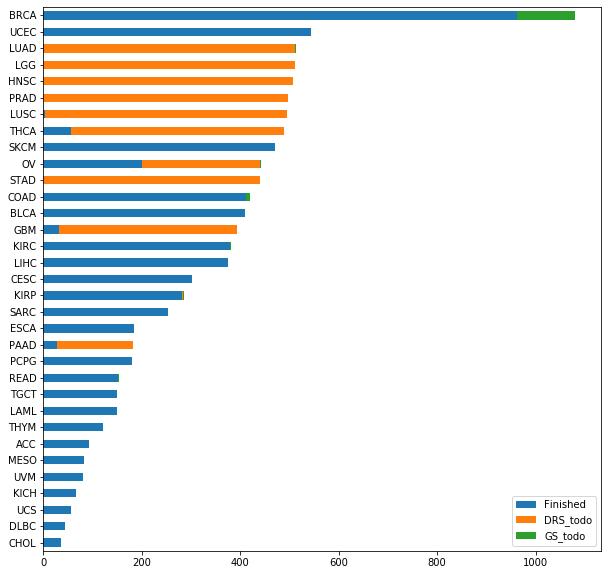

In [13]:
xx = prog.loc[:, ['total', 'DRS_todo', 'GS_todo']]
xx['Finished'] = xx['total'] - (xx['GS_todo'] + xx['DRS_todo'])

xx.sort_values(by = 'total').loc[:,['Finished', 'DRS_todo', "GS_todo"]].plot(kind = "barh", stacked=True, figsize = (10, 10))
plt.show()

In [14]:
finished_cohorts = prog.index[prog['%finished'].values == 1].tolist()

# [preprocess]: Parse MAFs as MutSig input

All funcotator annotated mafs will be stored in `/demo-mount/m2_results/[cohort]/[sample_id]/annot_merged_filtered.vcf`

The combined result from all samples for given cohort is stored in `/demo-mount/m2_results/combined_res/[cohort].maf`

For sites that is not passing all filters, I have stored them in `/demo-mount/m2_results/combined_res/filters/[cohort].tsv`


In [47]:
# subset MC3
MC3 = pd.read_csv("/demo-mount/M2_refs/MC3.maf", sep = "\t")
cols = ['Chromosome', 'Start_Position', 'Hugo_Symbol', 
        'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2',
        'Variant_Classification', 'Variant_Type']
type_converter = {'Missense_Mutation':'Missense',
                  'Intron':'IGR',
                  'Silent':'Synonymous',
                  'Nonsense_Mutation':'Nonsense',
                  'Splice_Site':'Splice_site',
                  'RNA':'IGR',
                  "3'UTR": 'IGR',
                  "5'UTR": 'IGR',
                  "5'Flank": 'IGR',
                  'DE_NOVO_START_IN_FRAME':'IGR',
                  'DE_NOVO_START_OUT_FRAME':'IGR', 
                  'Nonstop_Mutation':'Nonsense',
                  'START_CODON_SNP':'Nonsense'
                 }
chromosome_converter = {'X': '23', 'Y': '24'}
colname_converter = {'Hugo_Symbol':'gene',
                     'Chromosome':'chr',
                     'Start_Position':'pos',
                     'Reference_Allele':'ref_allele',
                     'Variant_Classification':'type',
                     'Variant_Type':'classification'
                    }
required_cols = MC3.columns.tolist()
def get_patient(pid):
    base_dir = "/".join(("/demo-mount/m2_results", pid.split("_")[0], pid))
    f= open( base_dir + "/tumor_name.txt", "r")
    patient = f.read()
    f.close()
    return patient

def find_newbase(ref, v1, v2):
    if v1 != ref:
        return v1
    else:
        return v2
    
def get_variants(pid):
    cohort= pid.split("_")[0]
    annot = "/".join(("/demo-mount/m2_results", cohort, pid, "annot_merged_filtered.vcf"))
    df = pd.read_csv(annot, sep = "\t", comment= "#", usecols=cols)
    
    # SNP only
    df = df.loc[df.Variant_Type == "SNP",:]
    
    # convert type
    df.Variant_Classification = df.Variant_Classification.replace(type_converter)
    
    # make sure the dataframe is not empty
    if df.shape[0] == 0:
        print("{} has no SNP called from Mutect2".format(pid))
        return df[required_cols]
    
    else:
        # find the altered base that is different from reference
        df["newbase"] = df.apply(lambda x: find_newbase(x['Reference_Allele'], x['Tumor_Seq_Allele1'], x['Tumor_Seq_Allele2']),axis=1)

        # rename colnames
        df = df.rename(columns = colname_converter)

        # add patient, cohort
        df["patient"] = get_patient(pid)
        df["ttype"] = cohort

        # make sure chromosome are string and convert X Y to 23, 24 accordingly
        df["chr"] = df["chr"].astype("str")
        df["chr"] = df["chr"].replace(chromosome_converter)
        df["chr"] = df["chr"].astype("int64")
        # slim
        df = df[required_cols]
    
    return df

def get_filtered(pid):
    patient = get_patient(pid)
    cohort= pid.split("_")[0]
    annot = "/".join(("/demo-mount/m2_results", cohort, pid, "merged_filtered.vcf"))
    df = pd.read_csv(annot, sep = "\t", comment= "#", header = None, usecols=range(8))
    df = df.loc[(df.iloc[:,3].str.len() == 1) & (df.iloc[:,4].str.len() == 1) & (df.iloc[:,6] != "PASS"),]
    df = df.iloc[:, [0,1,3,4,6,7]]
    df.columns = ["chr","pos","ref_allele", "newbase","filters","info"]
        # make sure chromosome are string and convert X Y to 23, 24 accordingly
    df["chr"] = df["chr"].astype("str")
    df["chr"] = df["chr"].replace(chromosome_converter)
    df["chr"] = df["chr"].astype("int64")
    df['patient'] = patient
    return df




In [71]:
# a function to parse all finished cohort

def parse_annot(COHORT) :
    print(COHORT)
    PID_fin = [os.path.basename(x) for x in glob("/demo-mount/m2_results/{}/*".format(COHORT))]
    Frame = pd.DataFrame()
    for i, pid in enumerate(PID_fin):
        i = i + 1
        if i%20 == 0:
            print(i, pid)
        try: 
            newdf = get_variants(pid)
            Frame = Frame.append(pd.DataFrame(data = newdf), ignore_index=True)
        except:
            print(i, pid, "error. The results are not included in the final maf")
    Frame.to_csv("/demo-mount/m2_results/combined_res/{}.maf".format(COHORT), sep = "\t", index = False)
    return(Frame)

def parse_filter(COHORT) :
    print(COHORT)
    PID_fin = [os.path.basename(x) for x in glob("/demo-mount/m2_results/{}/*".format(COHORT))]
    Filter = pd.DataFrame()
    for i, pid in enumerate(PID_fin):
        i = i + 1
        if i%30 == 0:
            print(i, pid)
        try: 
            newdf = get_filtered(pid)
            Filter = Filter.append(pd.DataFrame(data = newdf), ignore_index=True)
        except:
            print(i, pid, "error. The results are not included in the final maf")
    Filter.to_csv("/demo-mount/m2_results/combined_res/filters/{}.tsv".format(COHORT), sep = "\t", index = False)
    return(Filter)



for cc in finished_cohorts:
    parse_filter(cc)

ACC
30 ACC_OR-A5JK
60 ACC_OR-A5LR
72 ACC_OR-A5JL error. The results are not included in the final maf
90 ACC_OR-A5LN
BLCA
30 BLCA_BT-A20U
60 BLCA_2F-A9KO
90 BLCA_XF-A8HG
120 BLCA_DK-A3WW
150 BLCA_ZF-AA5N
180 BLCA_ZF-AA53
210 BLCA_FD-A6TI
240 BLCA_BT-A20Q
270 BLCA_GC-A4ZW
300 BLCA_DK-A3IM
330 BLCA_XF-A8HH
360 BLCA_CF-A5U8
390 BLCA_GC-A3RC
CESC
30 CESC_Q1-A5R2
60 CESC_EA-A3HT
90 CESC_JW-A5VL
120 CESC_VS-A8QC
150 CESC_C5-A1BF
180 CESC_HM-A3JK
210 CESC_IR-A3LC
240 CESC_MY-A5BE
270 CESC_EA-A556
300 CESC_DS-A5RQ
CHOL
23 CHOL_W5-AA2Q error. The results are not included in the final maf
30 CHOL_W5-AA39
DLBC
30 DLBC_GS-A9TY
ESCA
30 ESCA_VR-A8EZ
60 ESCA_LN-A5U5
90 ESCA_VR-AA7I
120 ESCA_LN-A9FQ
150 ESCA_2H-A9GN
180 ESCA_LN-A7HV
KICH
30 KICH_KL-8332
60 KICH_KL-8326
LAML
30 LAML_AB-2875
60 LAML_AB-2939
90 LAML_AB-2891
120 LAML_AB-2912
LIHC
30 LIHC_KR-A7K7
60 LIHC_BC-A112


/home/qing/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


90 LIHC_LG-A9QC
120 LIHC_DD-A4NN
150 LIHC_CC-A7II
180 LIHC_XR-A8TG
210 LIHC_DD-A73C
240 LIHC_DD-A116
270 LIHC_MI-A75E
300 LIHC_RC-A7SB
330 LIHC_DD-A3A3
360 LIHC_G3-A3CK
MESO
30 MESO_3H-AB3U
60 MESO_UT-A97Y
PCPG
30 PCPG_QT-A5XM
60 PCPG_RW-A67X
90 PCPG_S7-A7WU
120 PCPG_QR-A70Q
150 PCPG_W2-A7HE
SARC
30 SARC_DX-AB30
60 SARC_DX-AB2O
90 SARC_MO-A47R
120 SARC_SI-A71P
150 SARC_DX-A3UD
180 SARC_PC-A5DK
210 SARC_X2-A95T
240 SARC_SG-A6Z4
SKCM
30 SKCM_GN-A9SD
60 SKCM_ER-A2NG
90 SKCM_EB-A4IQ
120 SKCM_DA-A3F5
150 SKCM_EE-A29R
180 SKCM_FS-A1ZH
210 SKCM_WE-A8ZN
240 SKCM_EE-A3J8
270 SKCM_EE-A3AH
300 SKCM_EE-A2MS
330 SKCM_LH-A9QB
360 SKCM_FS-A1ZF
390 SKCM_FS-A1ZM
420 SKCM_RP-A694
450 SKCM_WE-A8ZY
TGCT
30 TGCT_2G-AAHP
60 TGCT_2G-AAGV
90 TGCT_XE-AAO6
120 TGCT_YU-A94D
150 TGCT_2G-AAHA
THYM
30 THYM_XM-A8RE
60 THYM_XU-A92Y
90 THYM_4V-A9QX
120 THYM_X7-A8DI
UCEC
30 UCEC_BG-A0MO
60 UCEC_EO-A3AY
90 UCEC_D1-A16N
120 UCEC_B5-A11E
150 UCEC_B5-A1MX
180 UCEC_EY-A1GM
210 UCEC_D1-A0ZP
240 UCEC_BG-A0W2
270 UCEC_AP-A0LS


In [73]:
parse_annot("PCPG")

PCPG
20 PCPG_QR-A705
40 PCPG_QR-A70G
60 PCPG_RW-A67X
PCPG_TT-A6YO has no SNP called from Mutect2
73 PCPG_TT-A6YO error. The results are not included in the final maf
80 PCPG_SA-A6C2
100 PCPG_TT-A6YJ
120 PCPG_QR-A70Q
140 PCPG_QR-A70U
160 PCPG_WB-A81I


chr        pos    gene ref_allele newbase        type classification  \
0       3   52521842   NISCH          G       T  Synonymous            SNP   
1       5   80643655  ACOT12          G       A  Synonymous            SNP   
2       9  100961724  TBC1D2          G       C         IGR            SNP   
3      11     533874    HRAS          T       C    Missense            SNP   
4      11   70176459  PPFIA1          G       A         IGR            SNP   
...   ...        ...     ...        ...     ...         ...            ...   
2552    9  139118701   QSOX2          G       A  Synonymous            SNP   
2553   10   61833944    ANK3          C       T    Missense            SNP   
2554   12   53295659    KRT8          G       A  Synonymous            SNP   
2555   16    3350052   TIGD7          G       A    Missense            SNP   
2556   18   76886309   ATP9B          G       C    Missense            SNP   

                           patient ttype  
0     TCGA-P8-A5KD-01A-11D-A35D-08  PCPG  
1     TCGA-P8-A5KD-01A-11D-A35D-08  PCPG  
2     TCGA-P8-A5KD-01A-11D-A35D-08  PCPG  
3     TCGA-P8-A5KD-01A-11D-A35D-08  PCPG  
4     TCGA-P8-A5KD-01A-11D-A35D-08  PCPG  
...                            ...   ...  
2552  TCGA-QR-A70X-01A-11D-A35D-08  PCPG  
2553  TCGA-QR-A70X-01A-11D-A35D-08  PCPG  
2554  TCGA-QR-A70X-01A-11D-A35D-08  PCPG  
2555  TCGA-QR-A70X-01A-11D-A35D-08  PCPG  
2556  TCGA-QR-A70X-01A-11D-A35D-08  PCPG  

[2557 rows x 9 columns]

# [preprocess] filter MAFs by target list

First we need to make sure that chromosome index are mapped - we need to translate X and Y to integer values

In [54]:
df = pd.read_csv("/demo-mount/m2_results/combined_res/target_intervals/gencode.v19.basic.exome.bed", 
                 sep = "\t", header=None)
df.iloc[:,0] = df.iloc[:,0].replace(chromosome_converter)
df.to_csv("/demo-mount/m2_results/combined_res/target_intervals/gencode.v19.basic.exome.bed", 
          sep = "\t", index = None, header = None)

This is done by bedtools in a script 
```
#!/bin/bash

# the path to agilent target sequence
target_interval_bed="gencode.v19.basic.exome.bed"

# the path where all M2 mafs are stored
mafs_path="/demo-mount/for_Qing/sub_ttypes_mafs/*.maf"

for f in $mafs_path
do
echo $f
awk '{ print $1"\t"$2"\t"$2 }'  $f > ${f}.mid 
~/bdt intersect -a ${f}.mid -b $target_interval_bed -wa -u | awk '{ print $1"\t"$2}' > ${f}.target

done
```

Note that `maf_path` for M2 should be `/demo-mount/for_Qing/sub_ttypes_mafs/*.maf`, the path for M2 is `/demo-mount/m2_results/combined_res/target_intervals/*.maf`

Using bedtools, any line that matches at least one of the MC3 target list will be selected. The selected lines for each cohort are stored in `/demo-mount/m2_results/combined_res/[cohort].maf.target`. However only the first two column are matched (given the difference of bed file and maf file), we would need to join the selected loci with other MAF annotations.

In [76]:
def create_MAF_within_target(cohort, base_dir):
    # the base directory
    base_dir = "/demo-mount/m2_results/combined_res/"
    
    
    # read witin target region
    target = pd.read_csv(base_dir + "{}.maf.target".format(cohort), 
                         sep = "\t", names = ["chr", "pos"])
    target.chr = target.chr.astype('int64')
    # the original annotation
    annot = pd.read_csv(base_dir + "{}.maf".format(cohort), sep = "\t")
    
    # left join
    target = target.merge(annot, how = "left")
    target.to_csv(base_dir + "{}.target".format(cohort), 
                  sep = "\t", header = None, index = None)

    
M2_maf_dir = "/demo-mount/m2_results/combined_res/"
M1_maf_dir = "/demo-mount/for_Qing/sub_ttypes_mafs/"
for cc in finished_cohorts:
    create_MAF_within_target(cc, M2_maf_dir)
    create_MAF_within_target(cc, M1_maf_dir)

In [81]:
def n_SNV(maf1, maf2, ax):
    # compare per patient SNV counts
    vcount_per_patient = pd.DataFrame({"M2":maf2.patient.value_counts(), 
                                       "M1":maf1.patient.value_counts()})
    vcount_per_patient = vcount_per_patient.fillna(0)
    vcount_per_patient = vcount_per_patient.loc[vcount_per_patient.M1 != 0, :]
    vcount_per_patient.plot.scatter(x = "M1", y = "M2", ax=ax,s=50,
                                     title = "#SNV per patient", alpha=0.7)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.3, zorder=0, color = "red")
    diff = abs(vcount_per_patient.M1 - vcount_per_patient.M2)
    for i in diff.argsort()[-2:]:
        ax.annotate(vcount_per_patient.index.tolist()[i], 
                    (vcount_per_patient["M1"][i], vcount_per_patient["M2"][i]))
    return ax

def n_Cats(maf1, maf2, ax):
    mcats =pd.DataFrame({"M2":maf2["type"].value_counts(), "M1":maf1["type"].value_counts()})
    mcats = mcats.dropna()
    mcats = mcats.loc[mcats.M1 != 0, :]
    ax = mcats.plot.scatter(x = "M1", y = "M2", ax = ax, s=50,
                            title = "#variants per type")
    for i, txt in enumerate(mcats.index):
        ax.annotate(txt, (mcats["M1"][i], mcats["M2"][i]))
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.3, zorder=0, color = "red")
    #ax.plot([0,1],[0,1], transform=ax.transAxes, color="red", alpha=0.3)
    return ax

from matplotlib_venn import venn2
def venn(maf1 , maf2, ax):
    overlap = pd.merge(maf1, maf2, how='inner',on = ["chr", "pos","patient"])
    left = pd.merge(maf1, maf2, how='left',on = ["chr", "pos","patient"])
    right = pd.merge(maf1, maf2, how='right',on = ["chr", "pos","patient"])
    vsets = left.type_y.isna().sum(),  right.type_x.isna().sum(), overlap.shape[0]
    a=venn2(subsets = vsets, set_labels = ('M1', 'M2'), ax = ax)
    for t in a.subset_labels: t.set_fontsize(12)
    for t in a.set_labels: t.set_fontsize(15)
    return left, right

from upsetplot import from_memberships
from upsetplot import plot
def plot_upset(maf1, maf2, cohort):
    df = maf1.merge(maf2, on = ['patient', 'chr', 'pos'], how = "left")
    M1_only = df.loc[df.type_y.isna(), ['chr', 'pos', 'patient']]
    filter_df = pd.read_csv("/demo-mount/m2_results/combined_res/filters/{}.tsv".format(cohort), 
                            sep= '\t', index_col=None)
    filter_df['patient'] = filter_df['patient'].str[-23:]
    target = M1_only.merge(filter_df, on = ['patient', 'chr', 'pos'], how = 'left').dropna()
    #target = target[target]
    if target.shape[0] == 0:
        print("No M1-only calls are identified in filter-reasons")
        return(None)
    else:
        a = target.filters.str.split(pat=";", n=-1, expand=False).value_counts()
        plot(from_memberships(a.index.tolist(), a.tolist()))

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


(         chr        pos    gene ref_allele newbase         type  \
 8          1      14612     NaN          G       A          IGR   
 1214       1    1117120  TTLL10          G       A  Splice_site   
 1447       1    1153176    SDF4          G       A   Synonymous   
 1473       1    1154318     NaN          C       A          IGR   
 1825       1    1230156   ACAP3          G       A   Synonymous   
 ...      ...        ...     ...        ...     ...          ...   
 2987991   23  155255036     NaN          C       G          IGR   
 2988000   23  155255125     NaN          G       A          IGR   
 2988001   23  155255131     NaN          C       T          IGR   
 2988003   23  155255156     NaN          C       G          IGR   
 2988356   24    6948806   TBL1Y          T       C     Missense   
 
         classification                  patient ttype  
 8                  SNP  OR-A5LJ-01A-11D-A29I-10   ACC  
 1214               SNP  OR-A5KB-01A-11D-A30A-10   ACC  
 1447      

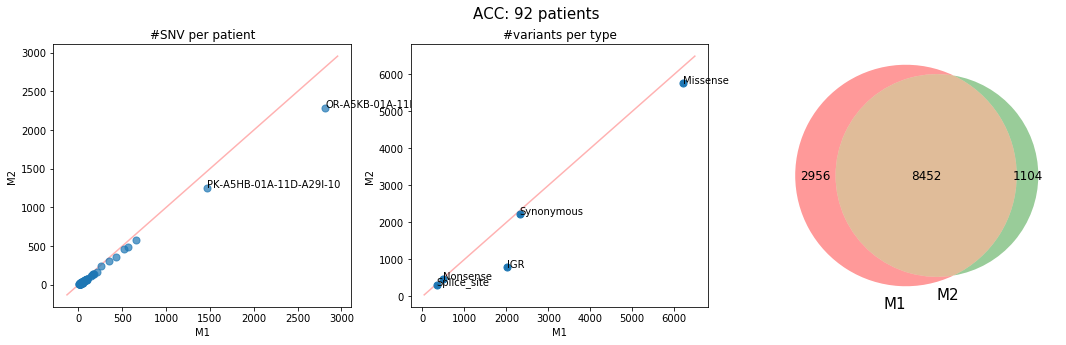

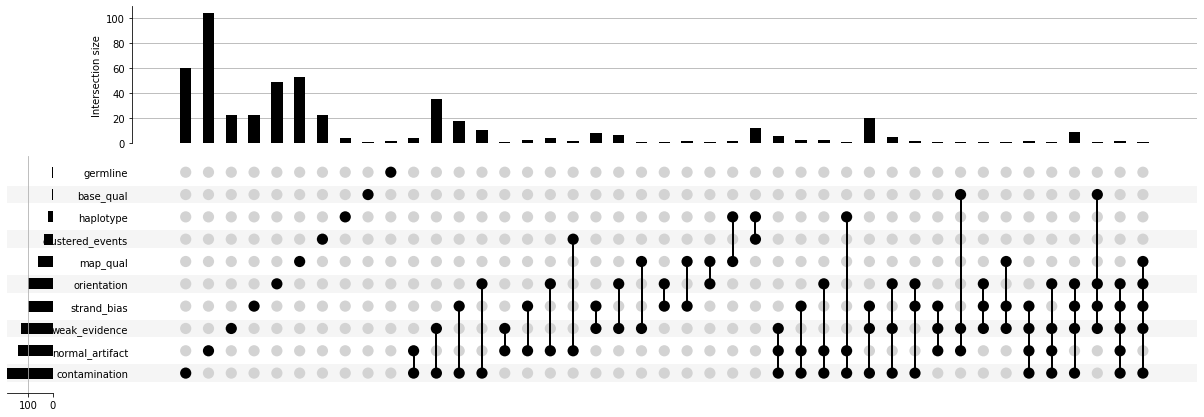

In [82]:
import numpy as np


def compare_vis(cohort = "ACC", get_maf = False):
    # define the paths
    
    
    maf1 = MC3.loc[MC3.ttype.isin([cohort]), ]
    
    if maf1.shape[0] == 0:
        print("MC3 does not contains", cohort)
        return(None)
    
    maf1["patient"] = maf1["patient"].str[-23:]
    maf2 = pd.read_csv("/demo-mount/m2_results/combined_res/{}.target".format(cohort), 
                       header = None, names=["chr", "pos", "gene", "ref_allele", 
                                             "newbase", "type", "classification", "patient", "ttype"],
                       index_col=None, sep = "\t")
    maf2["patient"] = maf2["patient"].str[-23:]
    # get all patient ids
    patient_files = glob("/demo-mount/m2_results/{}/*/tumor_name.txt".format(cohort))
    searchfor = []
    for pf in patient_files:
        with open(pf) as file:
            pp = file.read()
            searchfor.append(pp[-23:])
    maf1 = maf1.loc[maf1.patient.str.contains("|".join(searchfor)), :]
    if get_maf:
        return(maf1, maf2)
    
    fig10 = plt.figure(figsize = (15,5), constrained_layout=True)
    fig10.suptitle("{}: {} patients".format(cohort, len(searchfor)), fontsize=15)
    gs0 = fig10.add_gridspec(1, 1)

    gs00 = gs0[0].subgridspec(1, 3)


    ax00 = fig10.add_subplot(gs00[0, 0])
    ax01 = fig10.add_subplot(gs00[0, 1])
    ax02 = fig10.add_subplot(gs00[0, 2])
    
    ax_snv = n_SNV(maf1, maf2, ax = ax00)
    ax_cat = n_Cats(maf1, maf2, ax = ax01)
    left, right = venn(maf1, maf2, ax02)
    fig10.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/demo-mount/m2_results/combined_res/plots/align/{}-align.png'.format(cohort))
    
    plot_upset(maf1, maf2, cohort)
    plt.savefig('/demo-mount/m2_results/combined_res/plots/upset/{}-upset.png'.format(cohort))
    
    return(maf1, maf2)



compare_vis("ACC")

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


MC3 does not contains LAML


/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/qing/anaconda3/lib/python3.7/site-packages/upsetplot/plotting.py:578: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self._default_figsize)


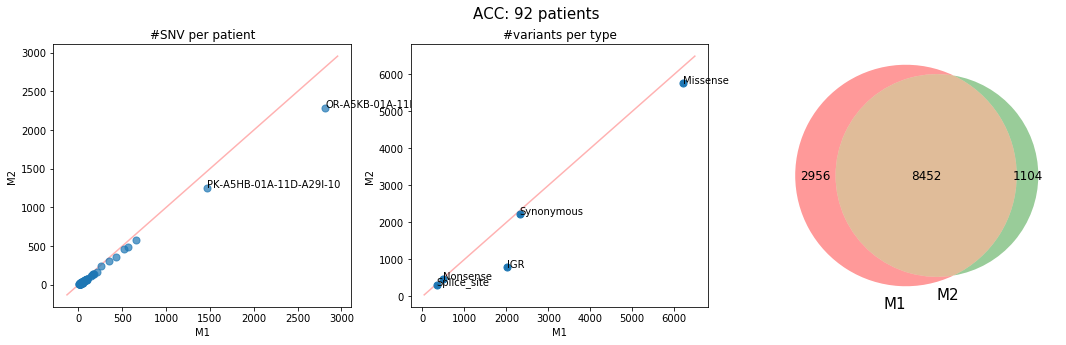

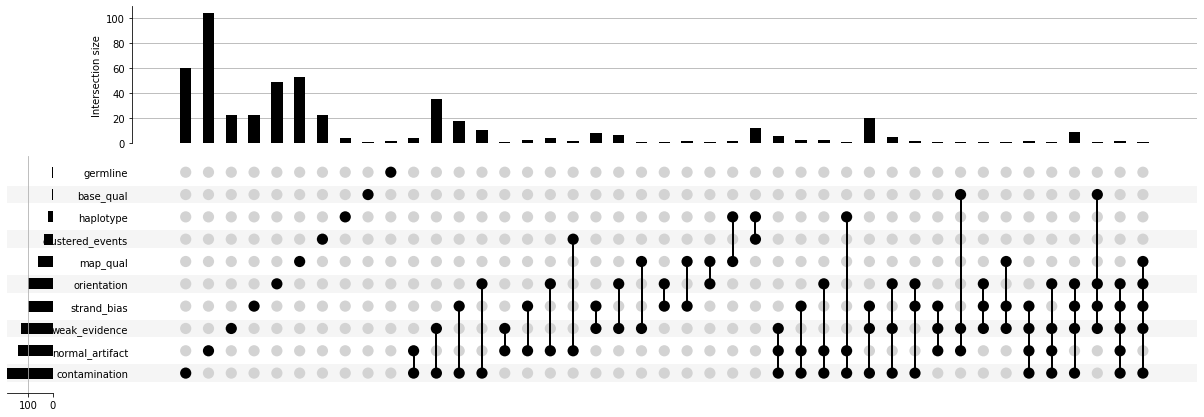

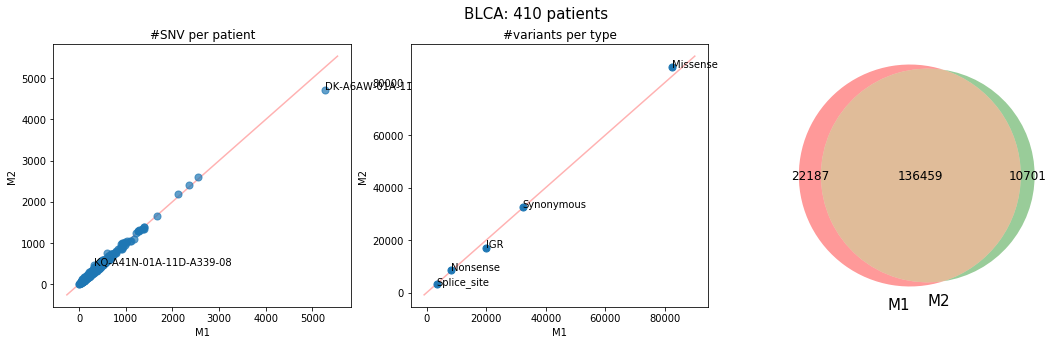

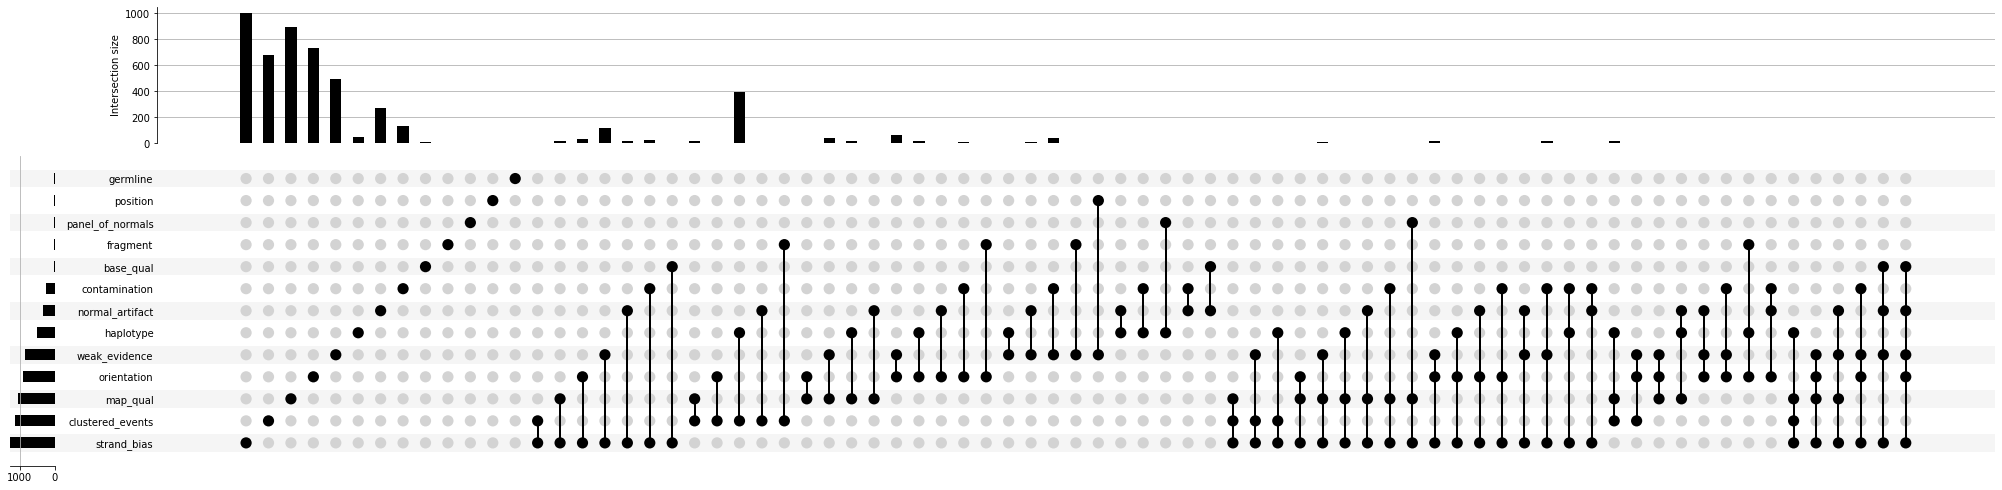

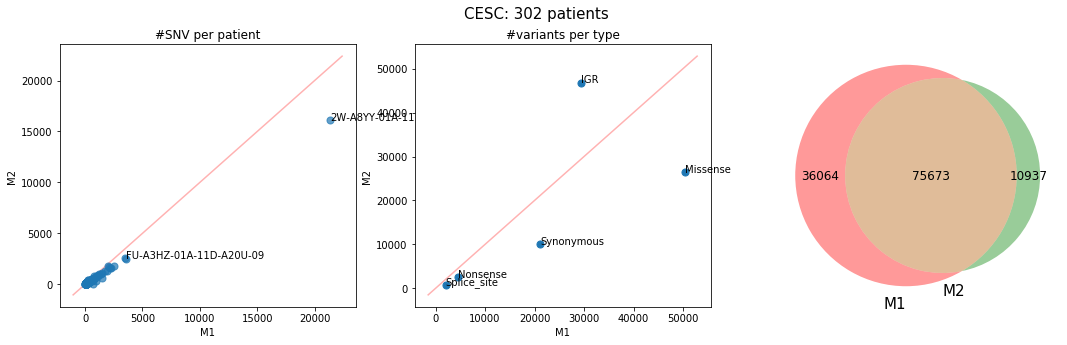

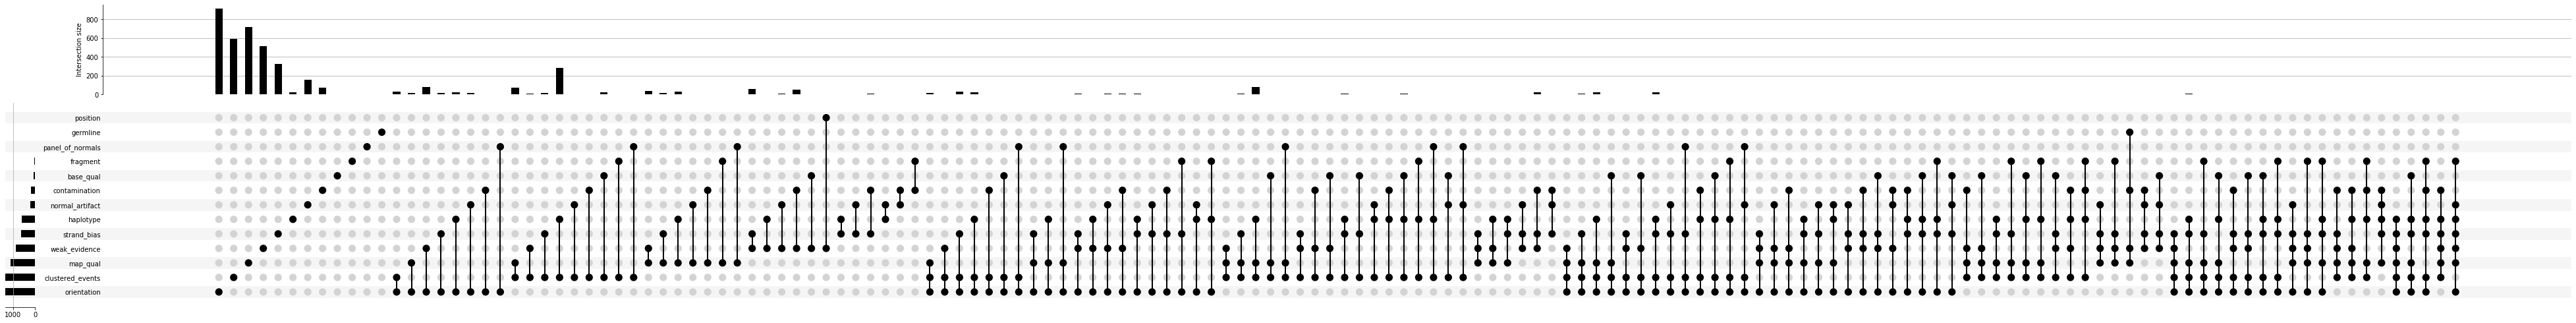

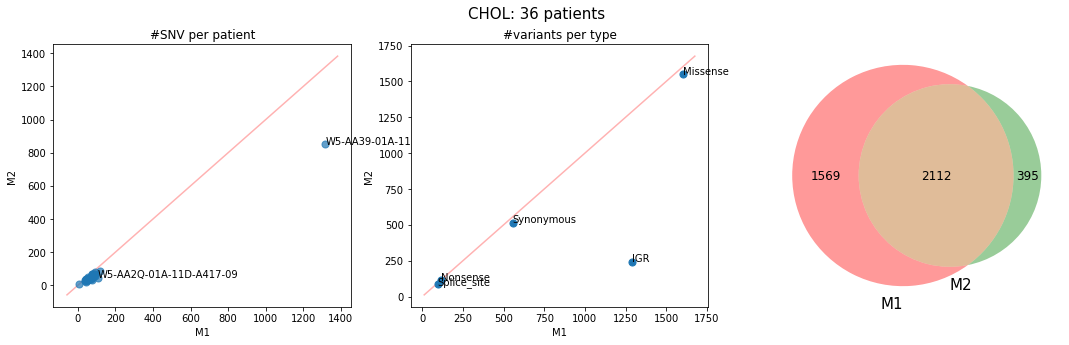

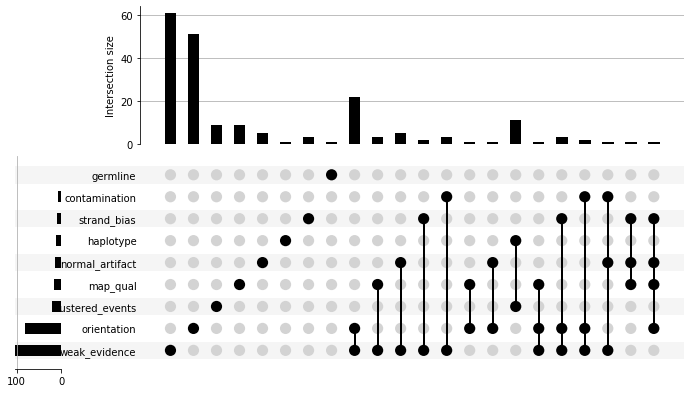

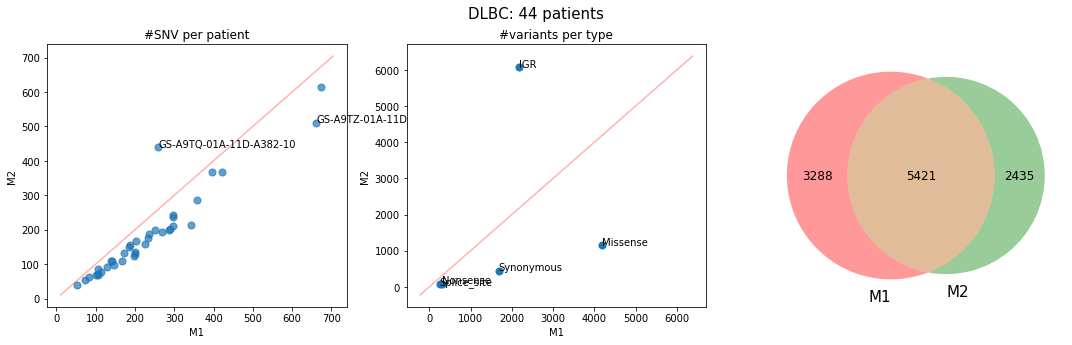

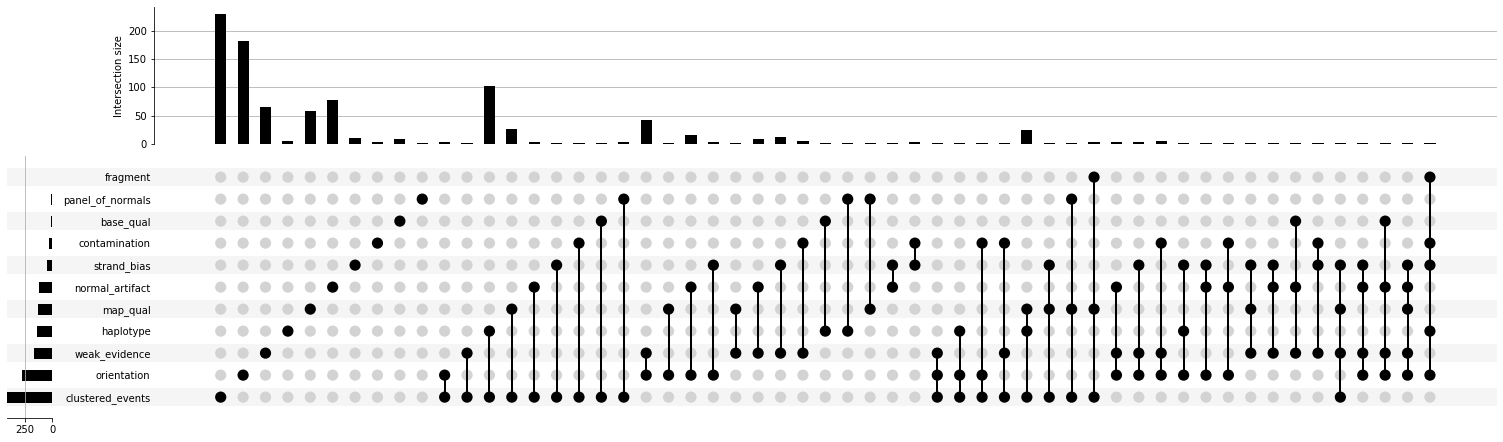

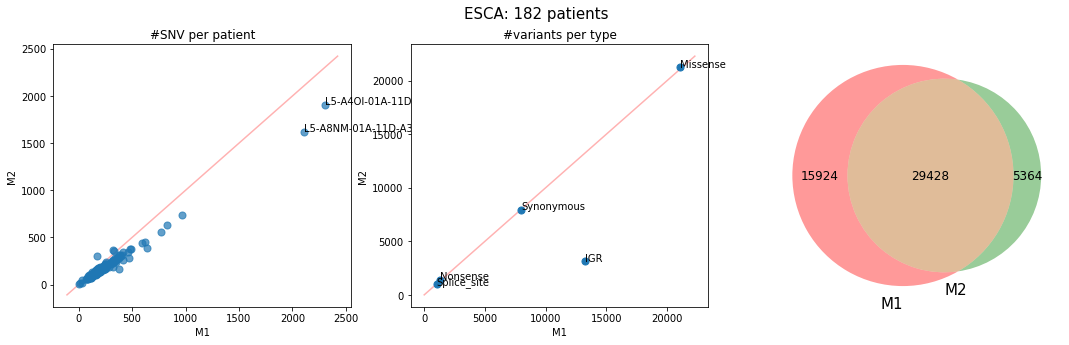

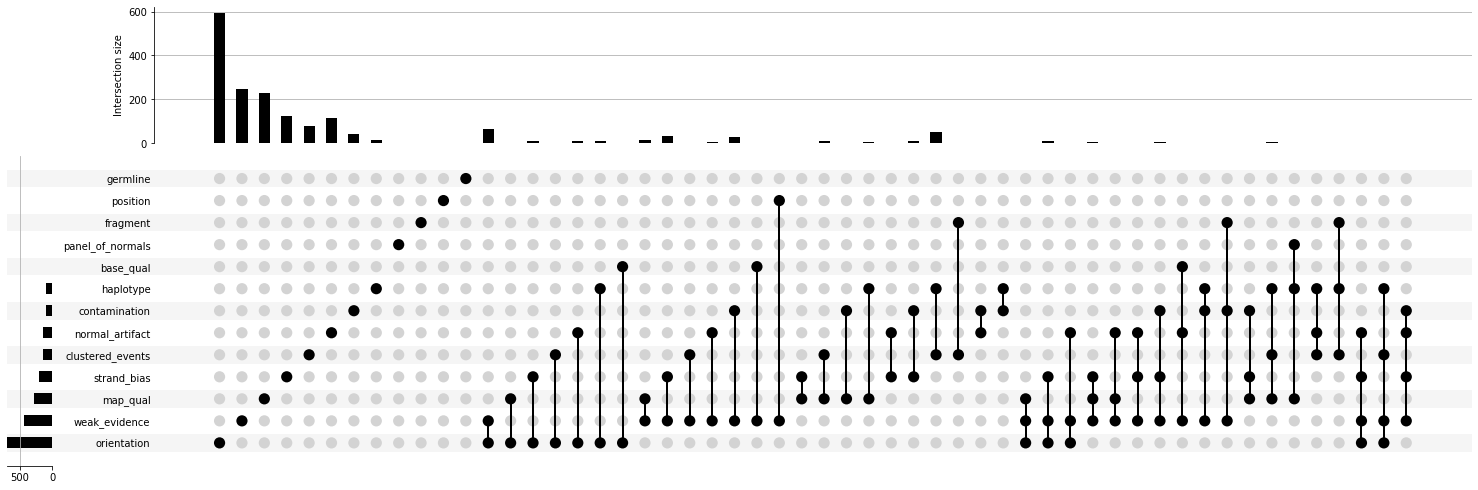

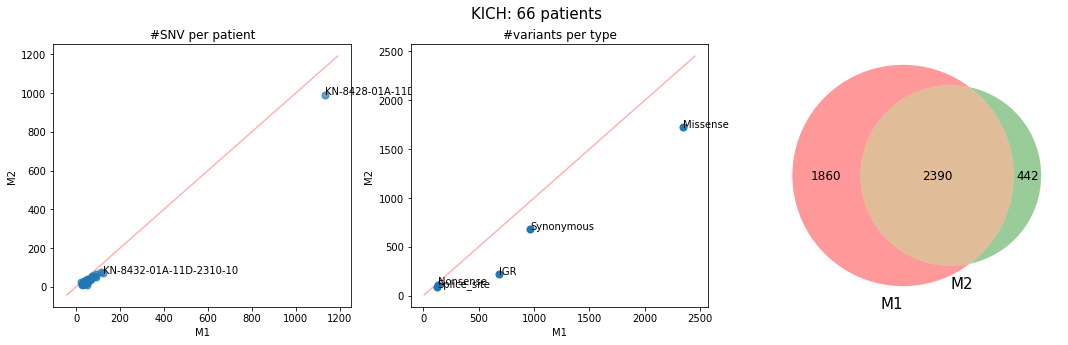

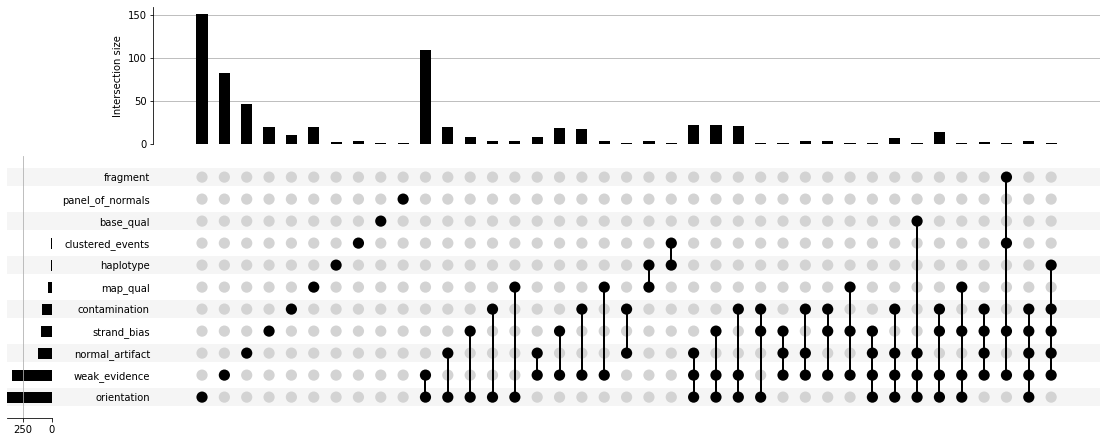

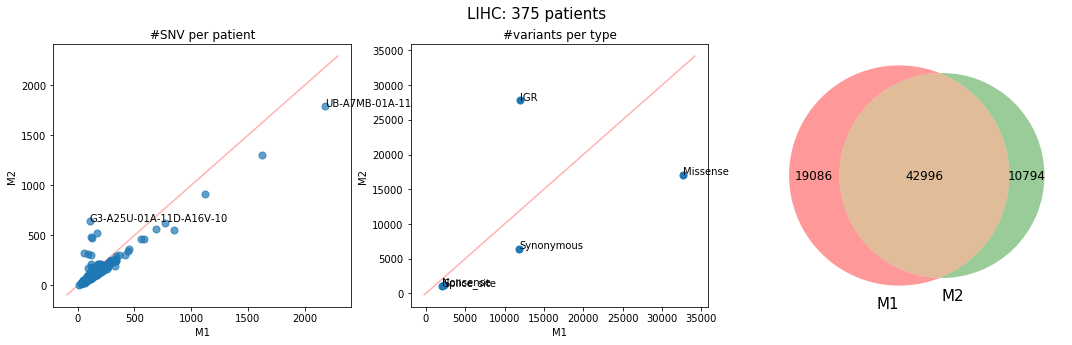

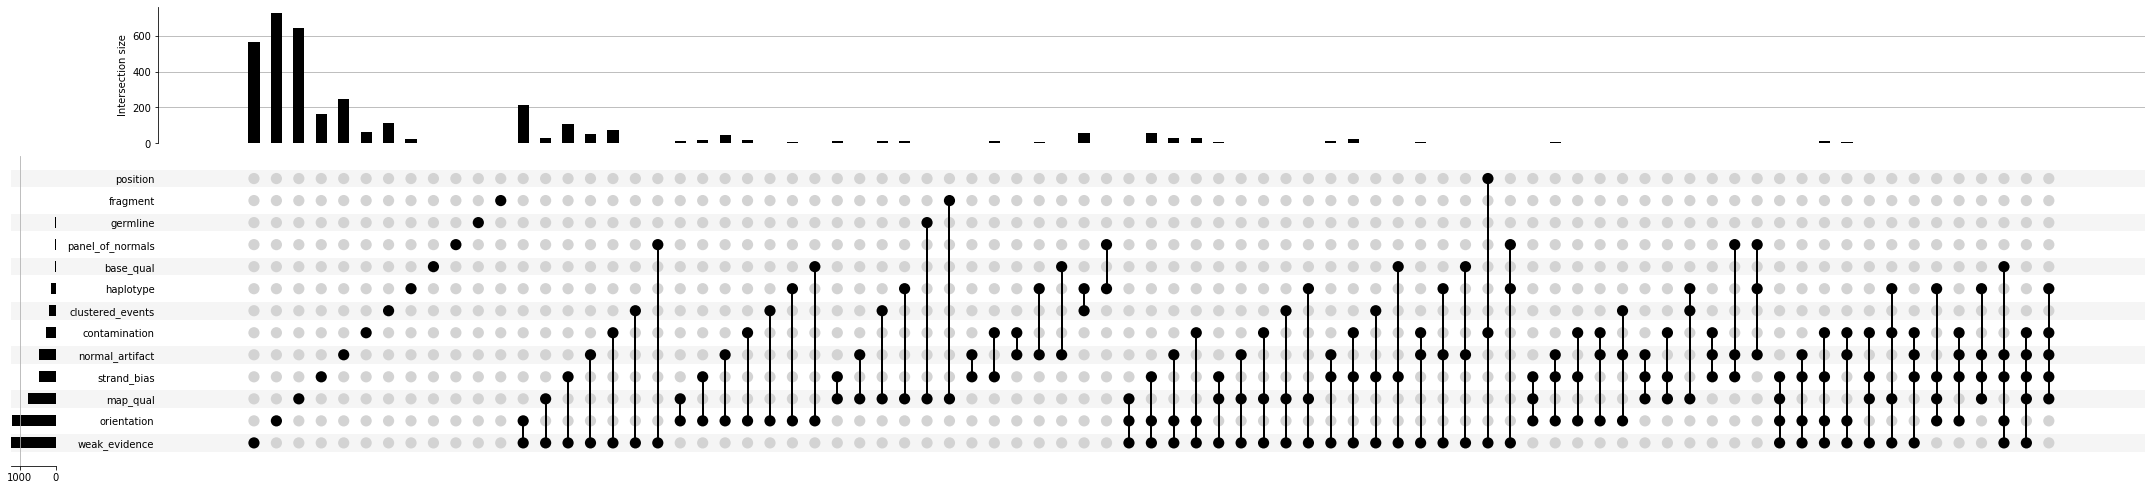

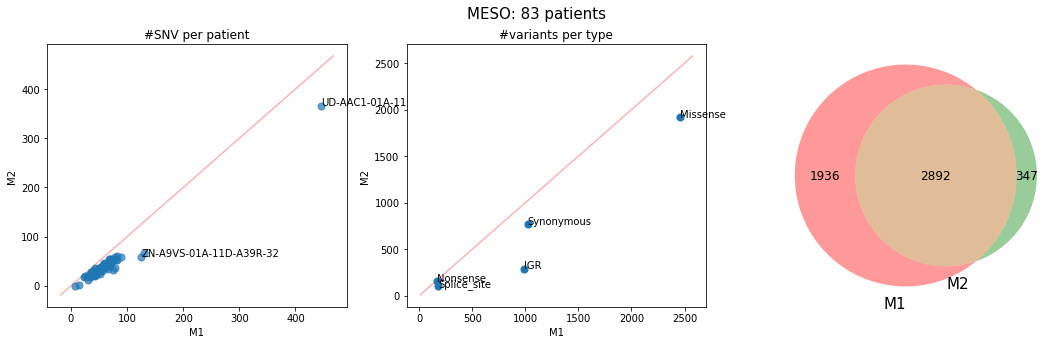

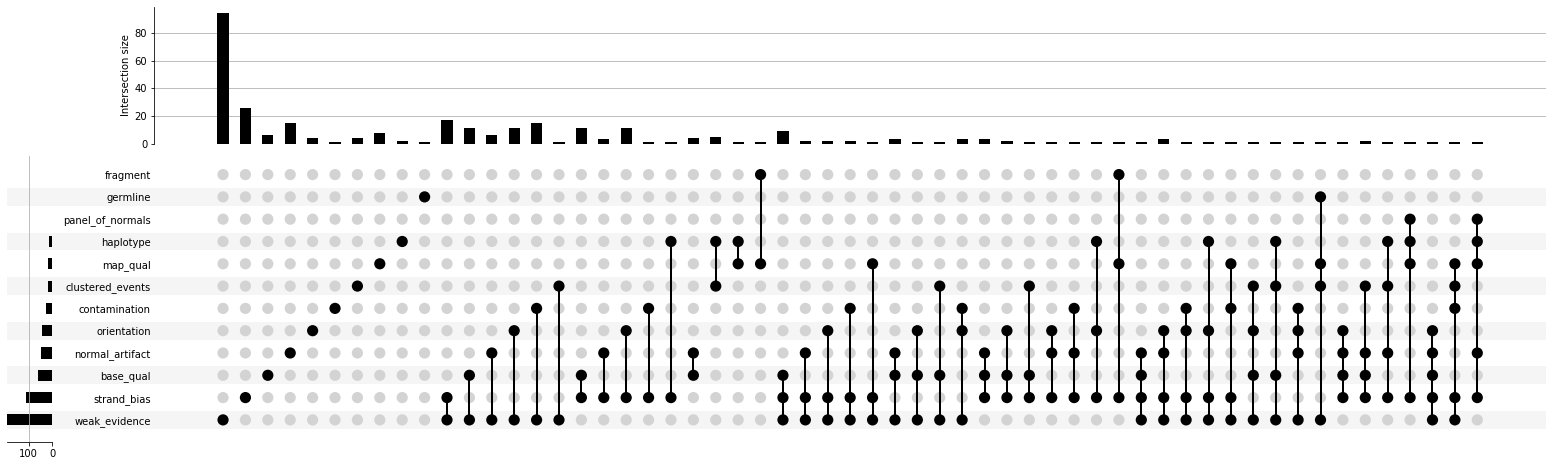

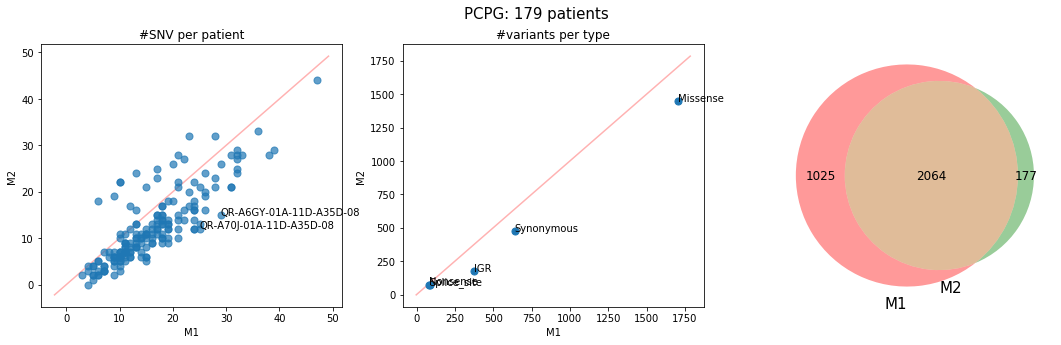

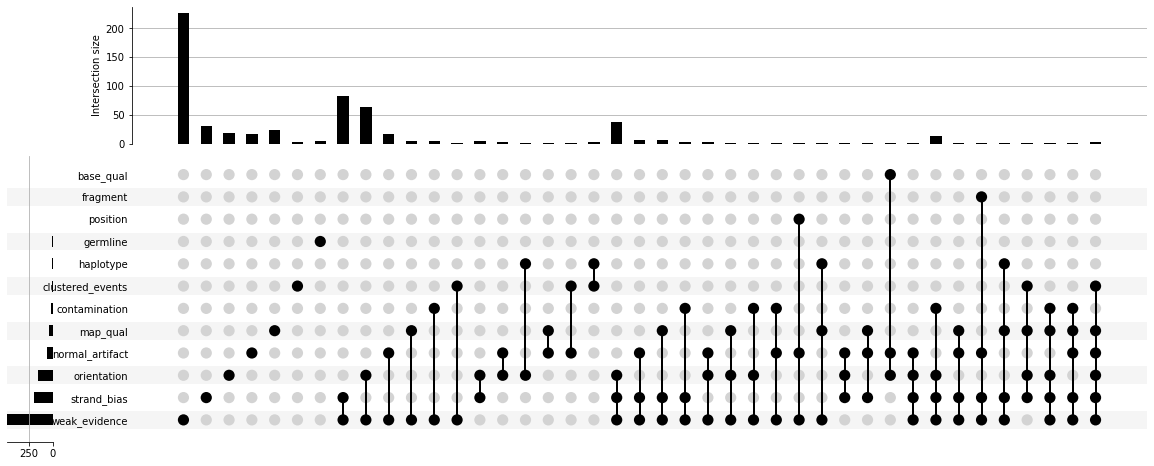

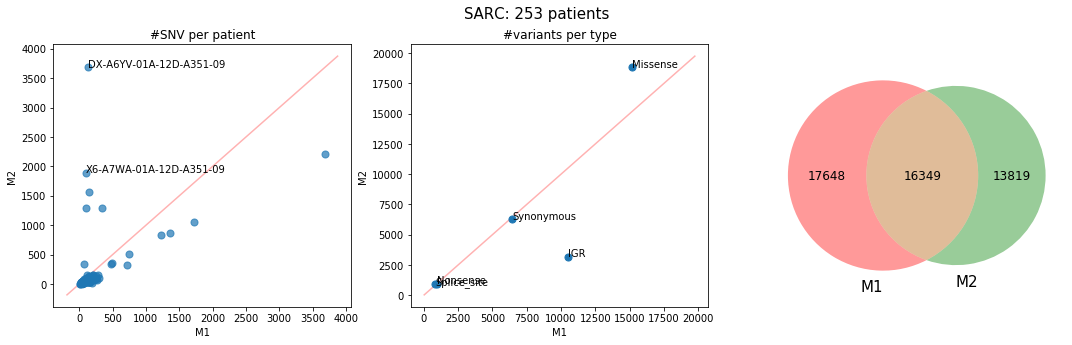

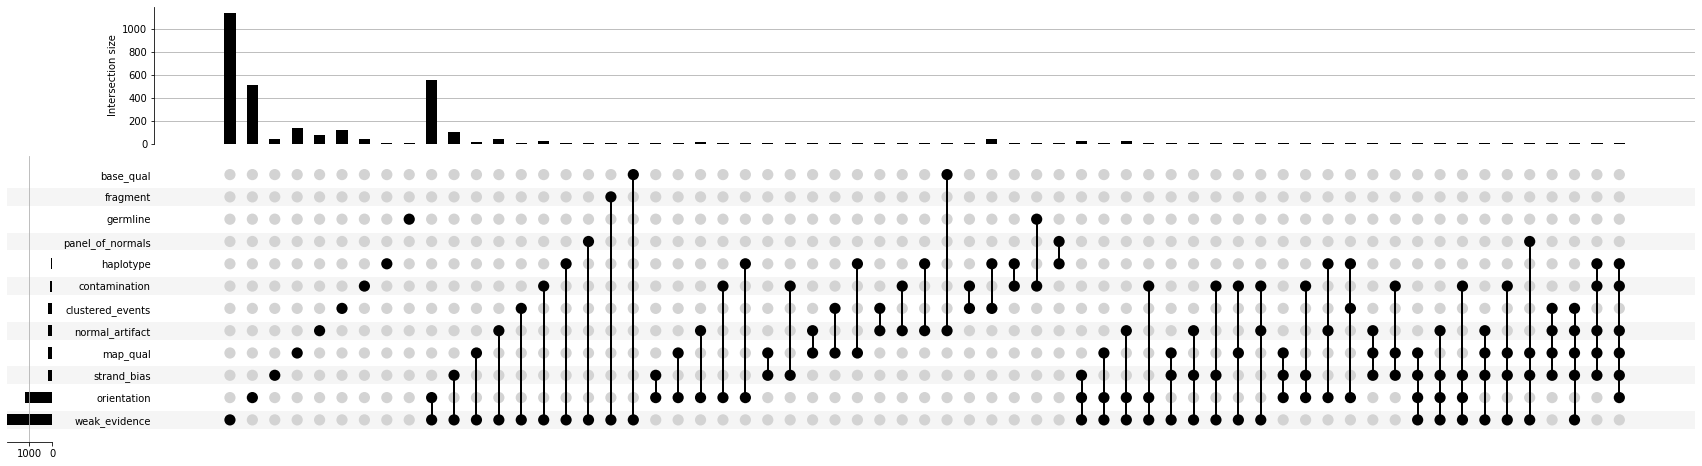

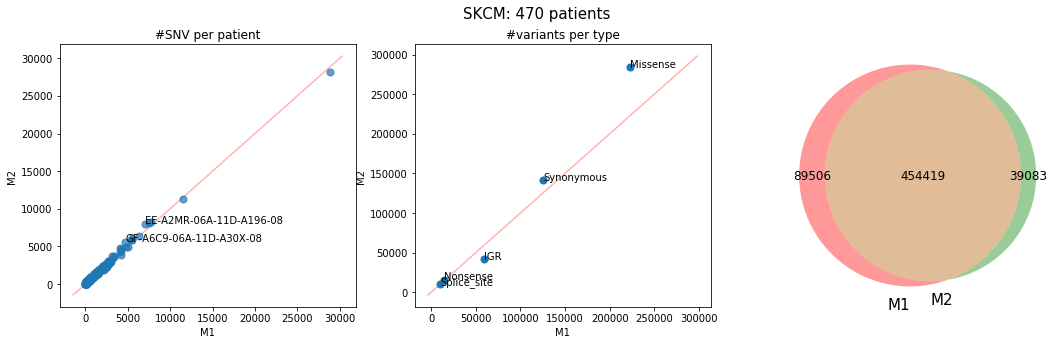

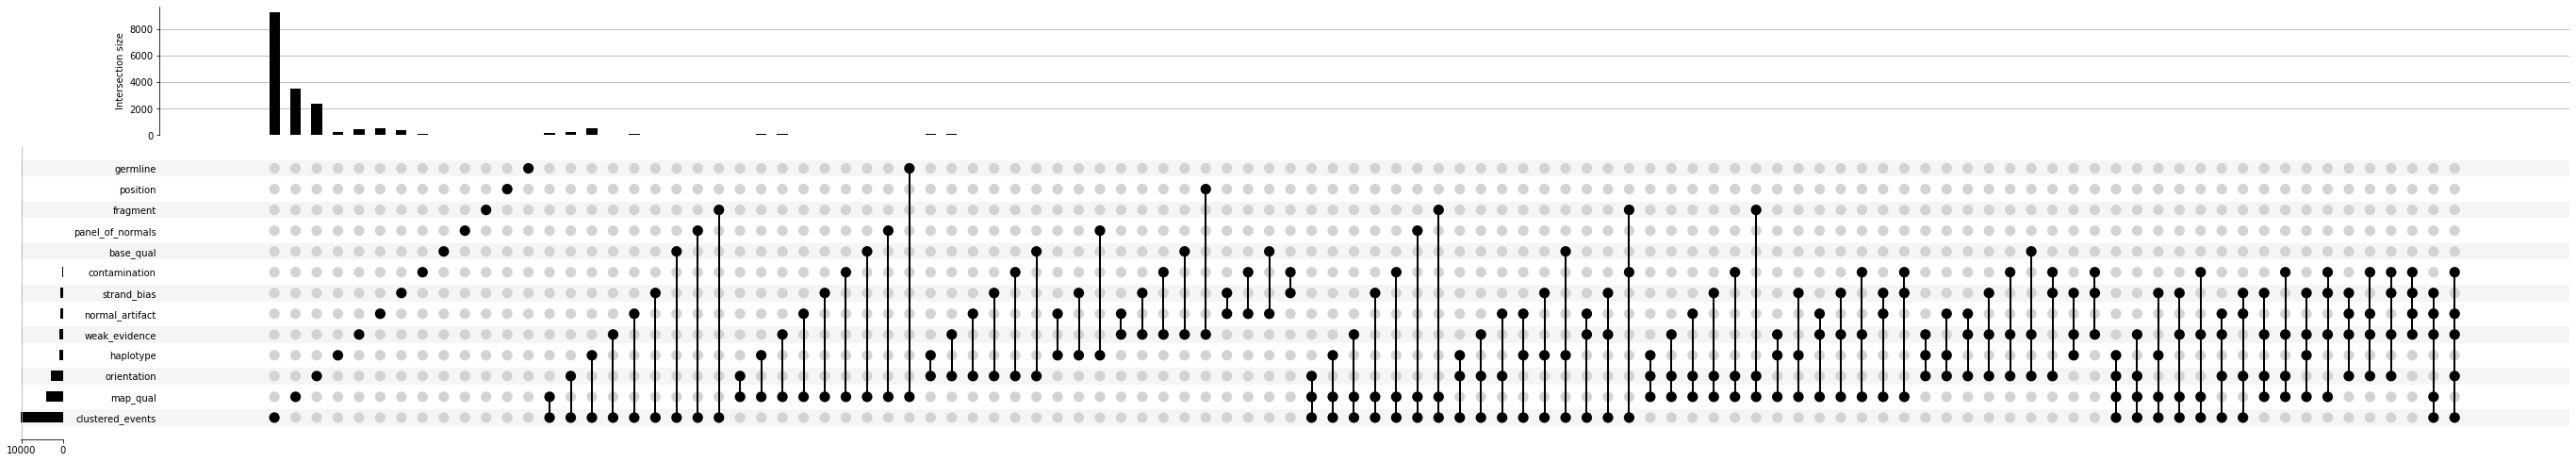

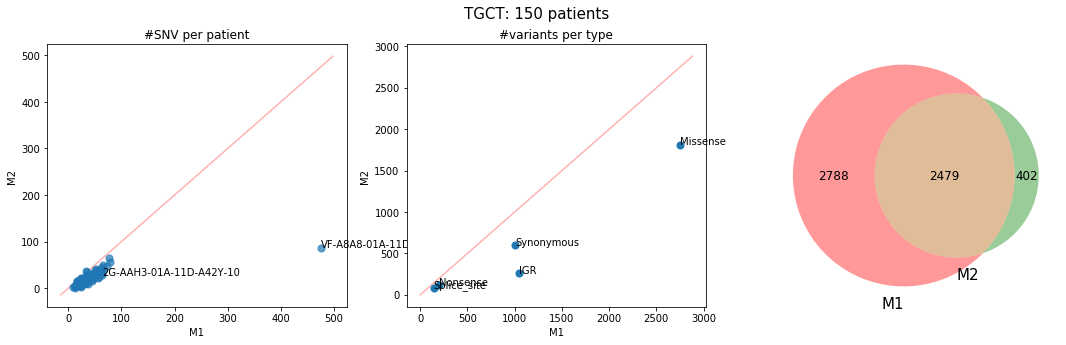

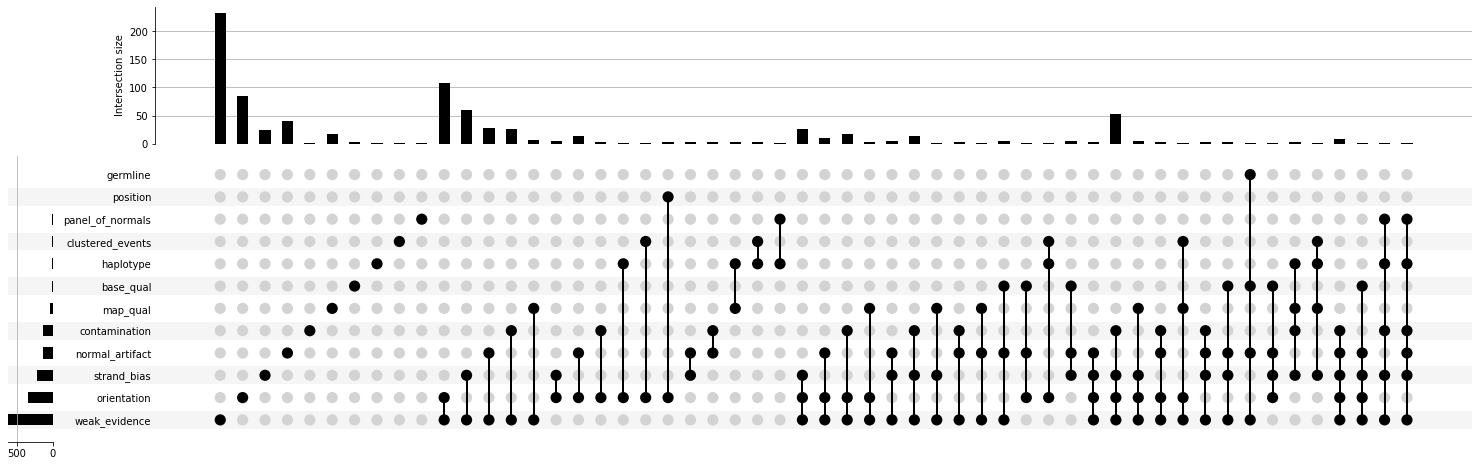

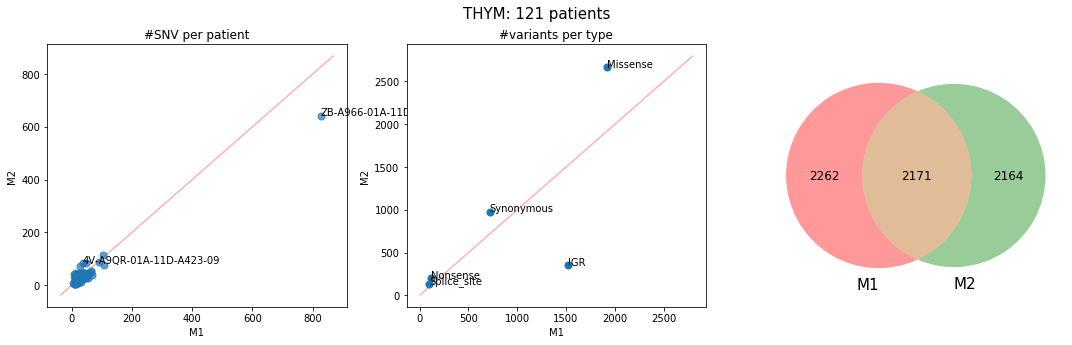

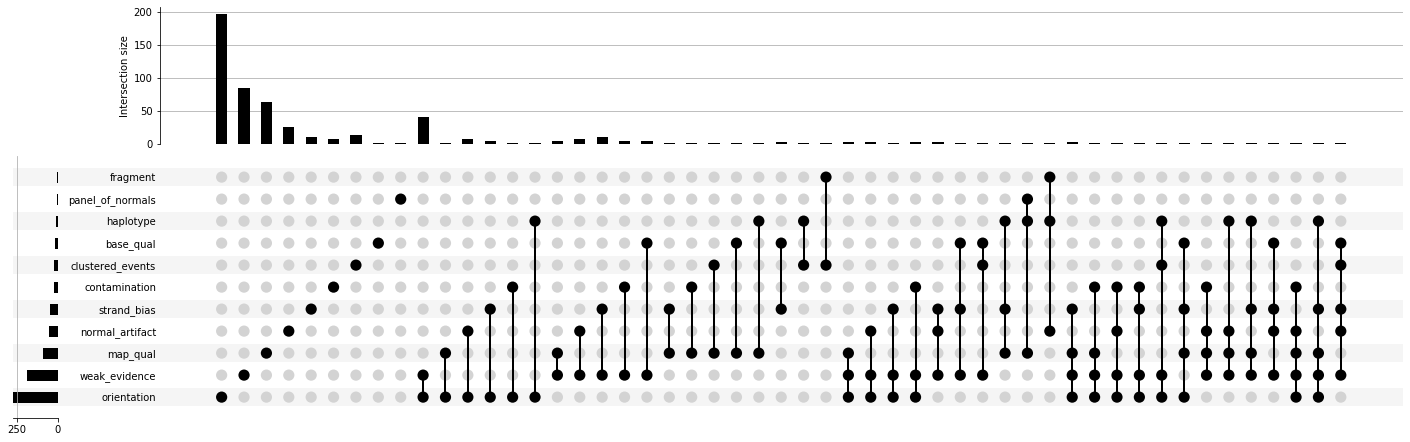

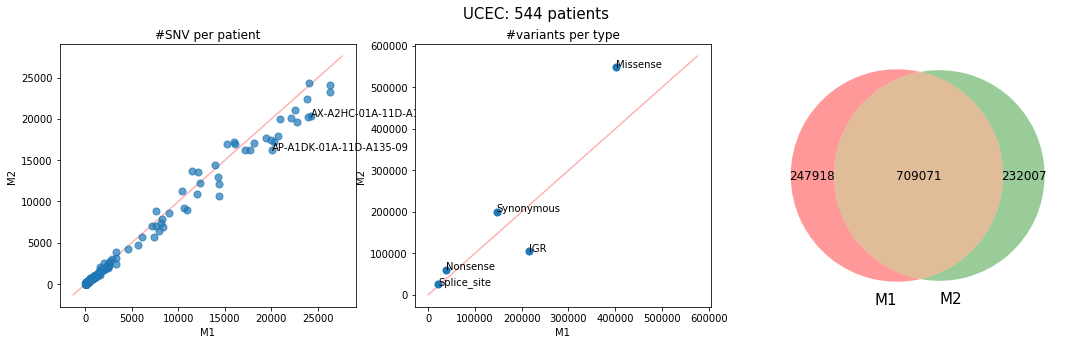

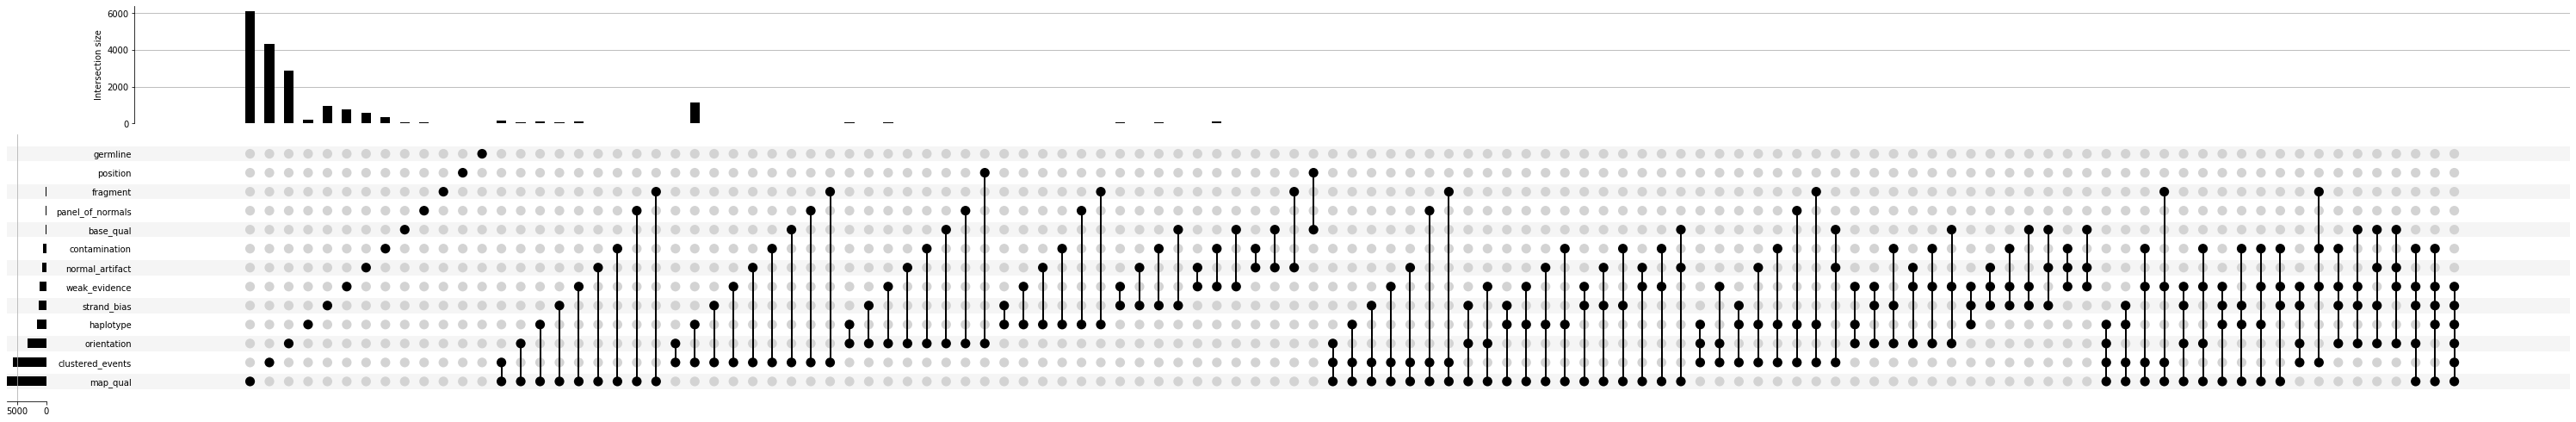

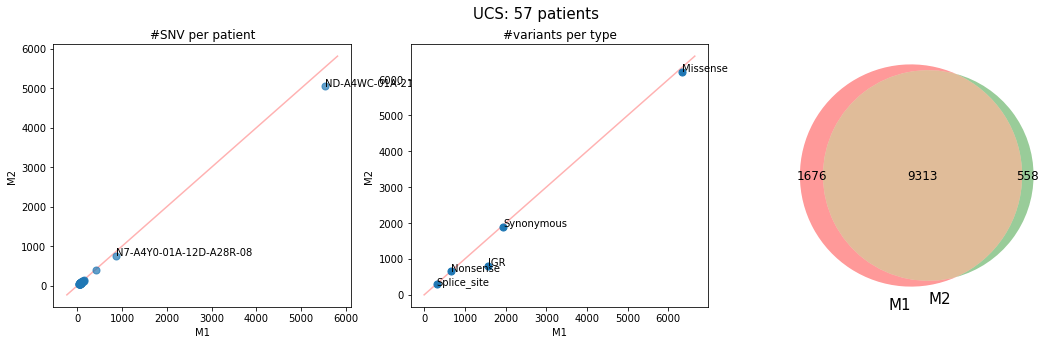

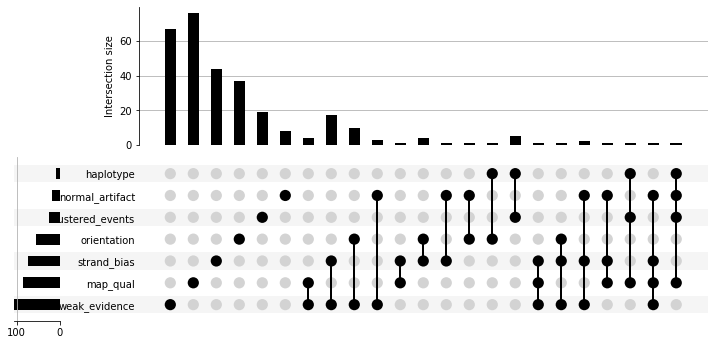

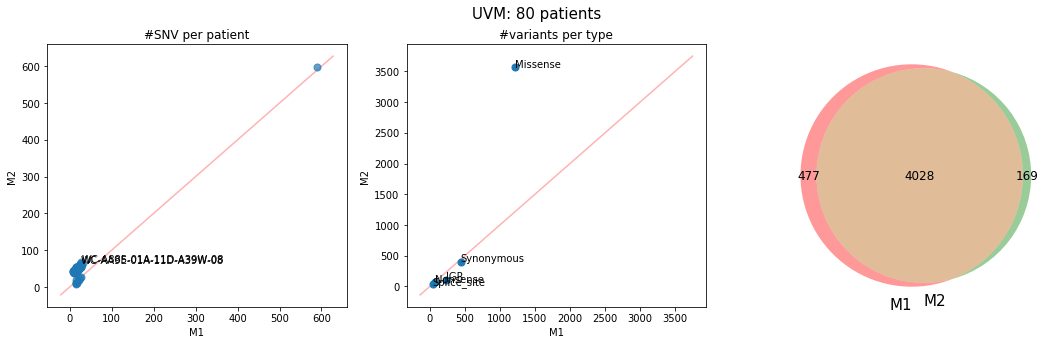

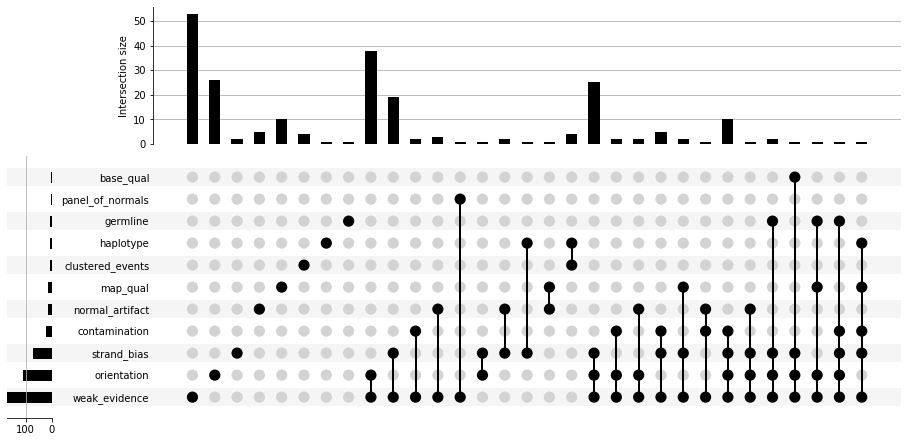

In [113]:
for cc in finished_cohorts:
    compare_vis(cc)

In [78]:
pd.read_csv("/demo-mount/m2_results/combined_res/{}.target".format(cohort), 
                       index_col=None, sep = "\t")

1  247694861    OR2C3  G  A    Missense  SNP  \
0      2  116497402    DPP10  C  A    Missense  SNP   
1      2  118582643    DDX18  T  C    Missense  SNP   
2      3   49050657     WDR6  C  A         IGR  SNP   
3      3   78680354    ROBO1  G  C    Missense  SNP   
4      3  196387312    NRROS  G  T  Synonymous  SNP   
...   ..        ...      ... .. ..         ...  ...   
9550  23   40458870  ATP6AP2  G  T    Missense  SNP   
9551  23  102471120     BEX4  C  T  Synonymous  SNP   
9552  23  133675462   MIR542  G  C         IGR  SNP   
9553  23  135432457   GPR112  A  G    Missense  SNP   
9554  23  153174968  ARHGAP4  G  A  Synonymous  SNP   

      TCGA-OR-A5LT-01A-11D-A29I-10  ACC  
0     TCGA-OR-A5LT-01A-11D-A29I-10  ACC  
1     TCGA-OR-A5LT-01A-11D-A29I-10  ACC  
2     TCGA-OR-A5LT-01A-11D-A29I-10  ACC  
3     TCGA-OR-A5LT-01A-11D-A29I-10  ACC  
4     TCGA-OR-A5LT-01A-11D-A29I-10  ACC  
...                            ...  ...  
9550  TCGA-OR-A5LI-01A-11D-A30A-10  ACC  
9551  TCGA-OR-A5LI-01A-11D-A30A-10  ACC  
9552  TCGA-OR-A5LI-01A-11D-A30A-10  ACC  
9553  TCGA-OR-A5LI-01A-11D-A30A-10  ACC  
9554  TCGA-OR-A5LI-01A-11D-A30A-10  ACC  

[9555 rows x 9 columns]

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


(         chr       pos   gene ref_allele newbase        type classification  \
 12         1     14889    NaN          G       T         IGR            SNP   
 14         1     14908    NaN          G       T         IGR            SNP   
 21         1     14955    NaN          G       A         IGR            SNP   
 29         1     15004    NaN          C       T         IGR            SNP   
 37         1     15140    NaN          C       T         IGR            SNP   
 ...      ...       ...    ...        ...     ...         ...            ...   
 2988740   24  21868176  KDM5D          C       T    Missense            SNP   
 2988743   24  21868341  KDM5D          G       A    Missense            SNP   
 2988753   24  21870833  KDM5D          C       T  Synonymous            SNP   
 2988777   24  21883189  KDM5D          C       T  Synonymous            SNP   
 2988796   24  22754339    NaN          G       C         IGR            SNP   
 
                          patient ttyp

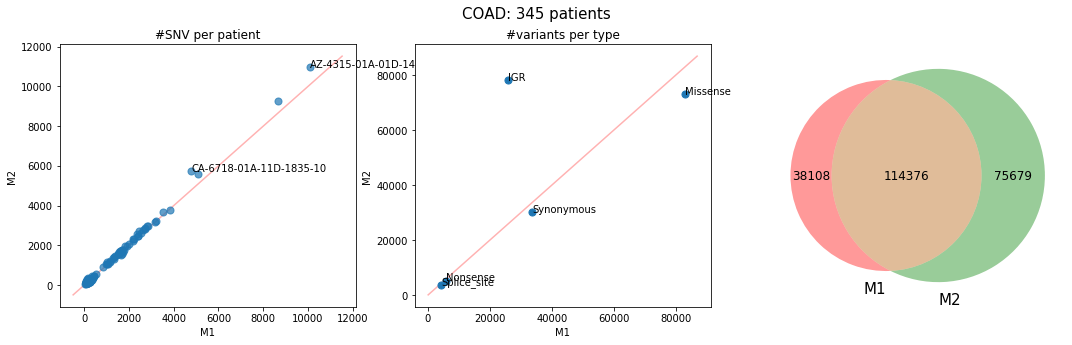

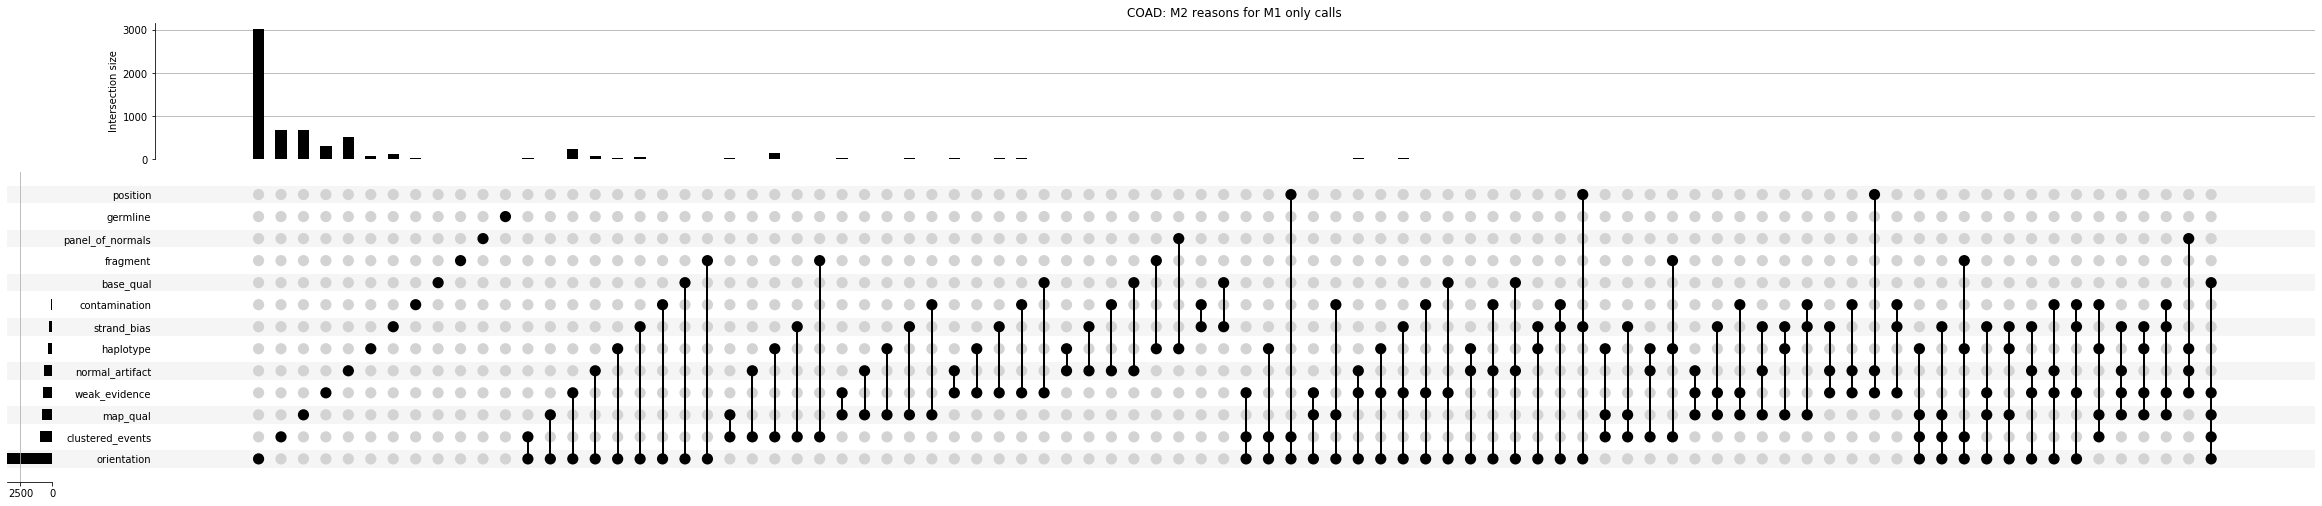

In [129]:
compare_vis("COAD")

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


(         chr        pos    gene ref_allele newbase      type classification  \
 11         1      14881     NaN          C       A       IGR            SNP   
 27         1      15003     NaN          C       G       IGR            SNP   
 58         1      16397     NaN          C       A       IGR            SNP   
 70         1      17479     NaN          G       A       IGR            SNP   
 106        1     569370     NaN          T       C       IGR            SNP   
 ...      ...        ...     ...        ...     ...       ...            ...   
 2987942   23  155239804    IL9R          C       G  Missense            SNP   
 2987999   23  155255118     NaN          C       T       IGR            SNP   
 2988104   24    4900721     NaN          T       A       IGR            SNP   
 2988677   24   16952640  NLGN4Y          C       T  Missense            SNP   
 2988722   24   21154479     NaN          C       G       IGR            SNP   
 
                          patient ttyp

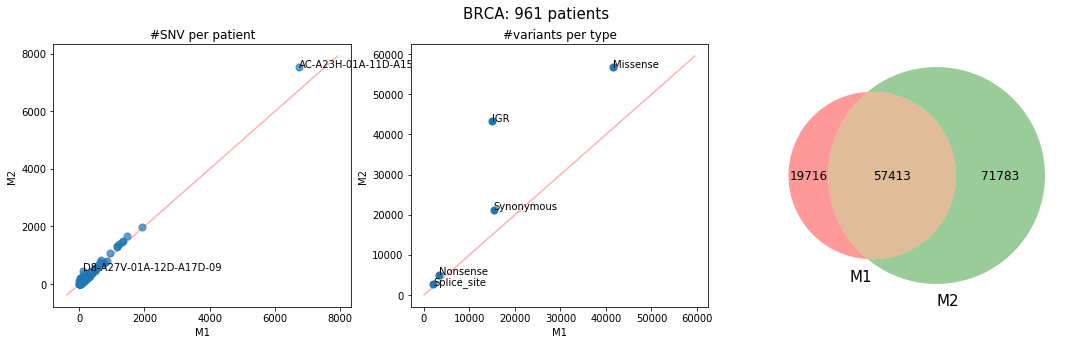

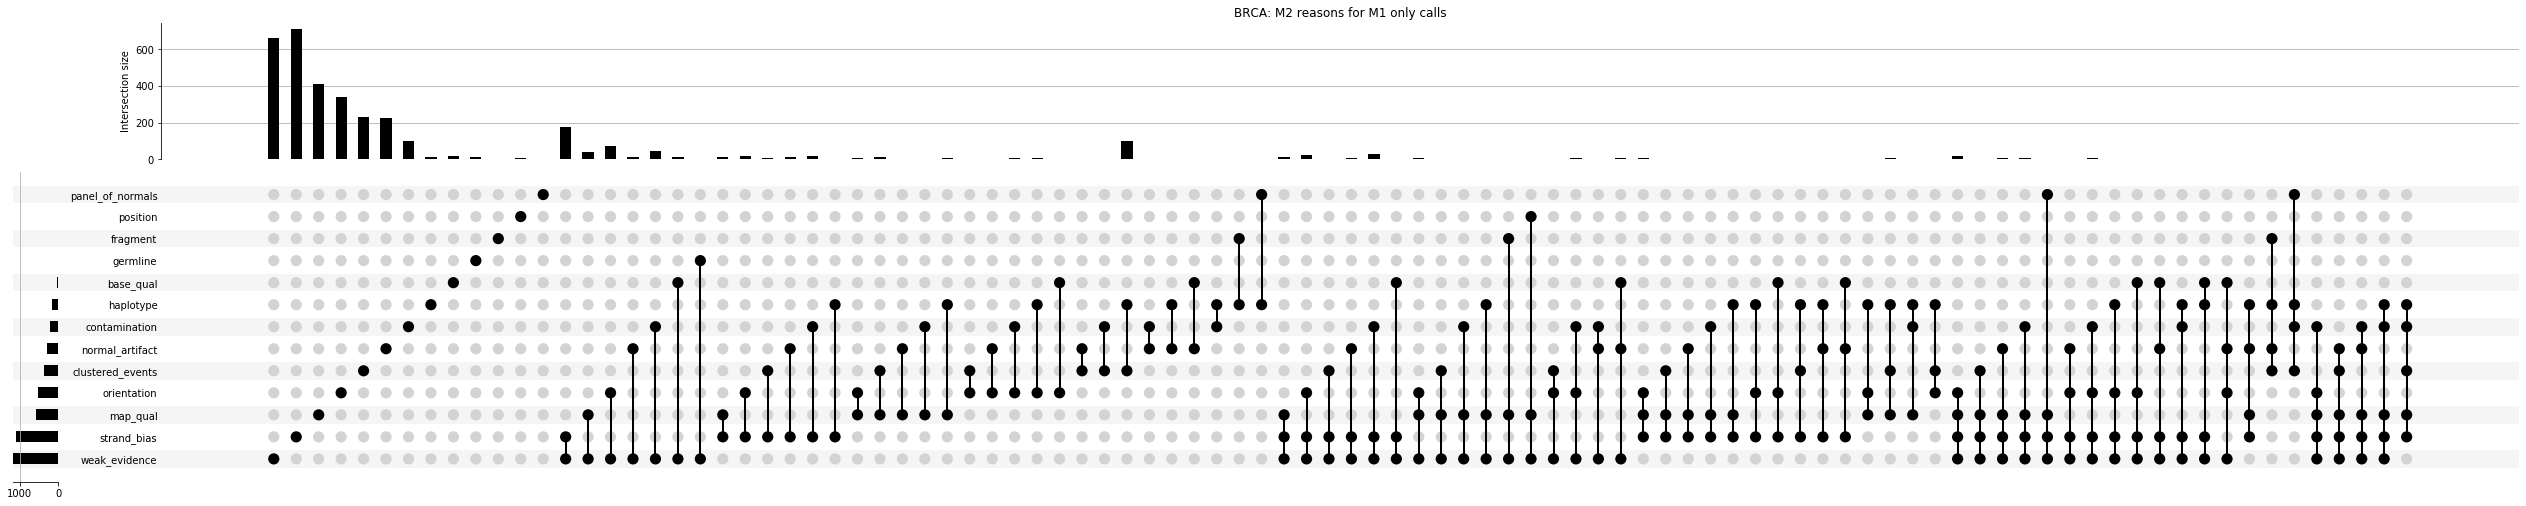

In [130]:
compare_vis("BRCA")

In [360]:
overlap = pd.merge(maf1, maf2, how='inner',on = ["chr", "pos","patient"])
left = pd.merge(maf1, maf2, how='left',on = ["chr", "pos","patient"])
right = pd.merge(maf1, maf2, how='right',on = ["chr", "pos","patient"])

In [361]:
M1_only = left.loc[right.type_x.isna(),["chr","pos","patient"]]

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


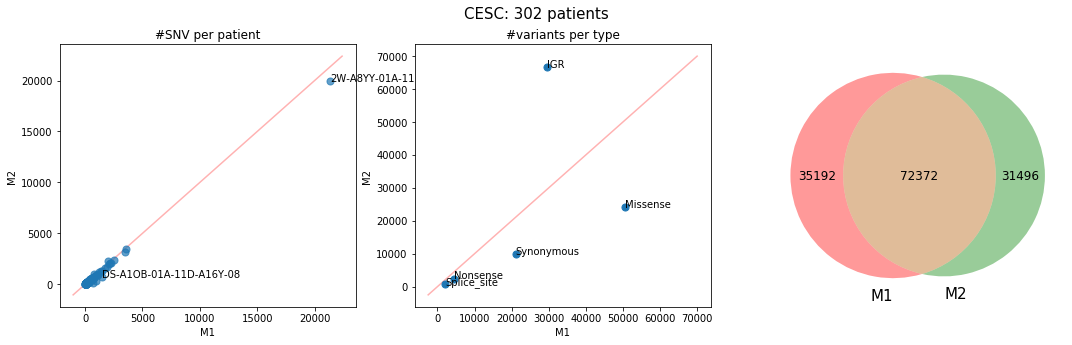

In [74]:
maf1, maf2 = compare_vis("CESC")

In [80]:
M1_only = maf1.merge(maf2, on = ['patient', 'chr', 'pos'], how = "left")

In [93]:
! wc -l /demo-mount/m2_results/combined_res/filters/*

 1 /demo-mount/m2_results/combined_res/filters/ACC.tsv
 1 /demo-mount/m2_results/combined_res/filters/BLCA.tsv
 1 /demo-mount/m2_results/combined_res/filters/CESC.tsv
 1 /demo-mount/m2_results/combined_res/filters/CHOL.tsv
 1 /demo-mount/m2_results/combined_res/filters/DLBC.tsv
 1 /demo-mount/m2_results/combined_res/filters/ESCA.tsv
 1 /demo-mount/m2_results/combined_res/filters/KICH.tsv
 1 /demo-mount/m2_results/combined_res/filters/LAML.tsv
 1 /demo-mount/m2_results/combined_res/filters/LIHC.tsv
 1 /demo-mount/m2_results/combined_res/filters/MESO.tsv
 1 /demo-mount/m2_results/combined_res/filters/SARC.tsv
 1 /demo-mount/m2_results/combined_res/filters/SKCM.tsv
 1 /demo-mount/m2_results/combined_res/filters/TGCT.tsv
 1 /demo-mount/m2_results/combined_res/filters/THYM.tsv
 1 /demo-mount/m2_results/combined_res/filters/UCEC.tsv
 1 /demo-mount/m2_results/combined_res/filters/UCS.tsv
 1 /demo-mount/m2_results/combined_res/filters/UVM.tsv
17 total


In [97]:
df = M1_only.loc[M1_only.type_y.isna(), ['chr', 'pos', 'patient']]
filter_df = pd.read_csv("/demo-mount/m2_results/combined_res/filters/CESC.tsv", sep= '\t', index_col=None)

In [106]:
a = df.merge(filter_df, on = ['patient', 'chr', 'pos'], how = 'left')

In [108]:
a.dropna()

Empty DataFrame
Columns: [chr, pos, gene_x, ref_allele_x, newbase_x, type_x, classification_x, patient, ttype_x, gene_y, ref_allele_y, newbase_y, type_y, classification_y, ttype_y, ref_allele, newbase, filters, info]
Index: []

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


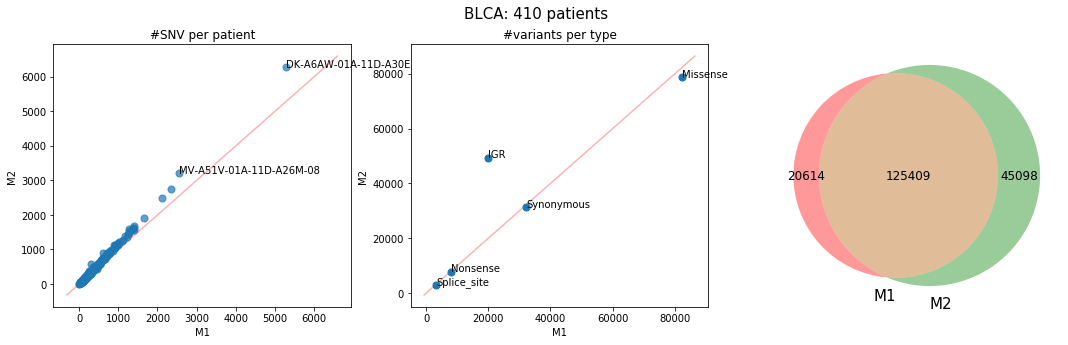

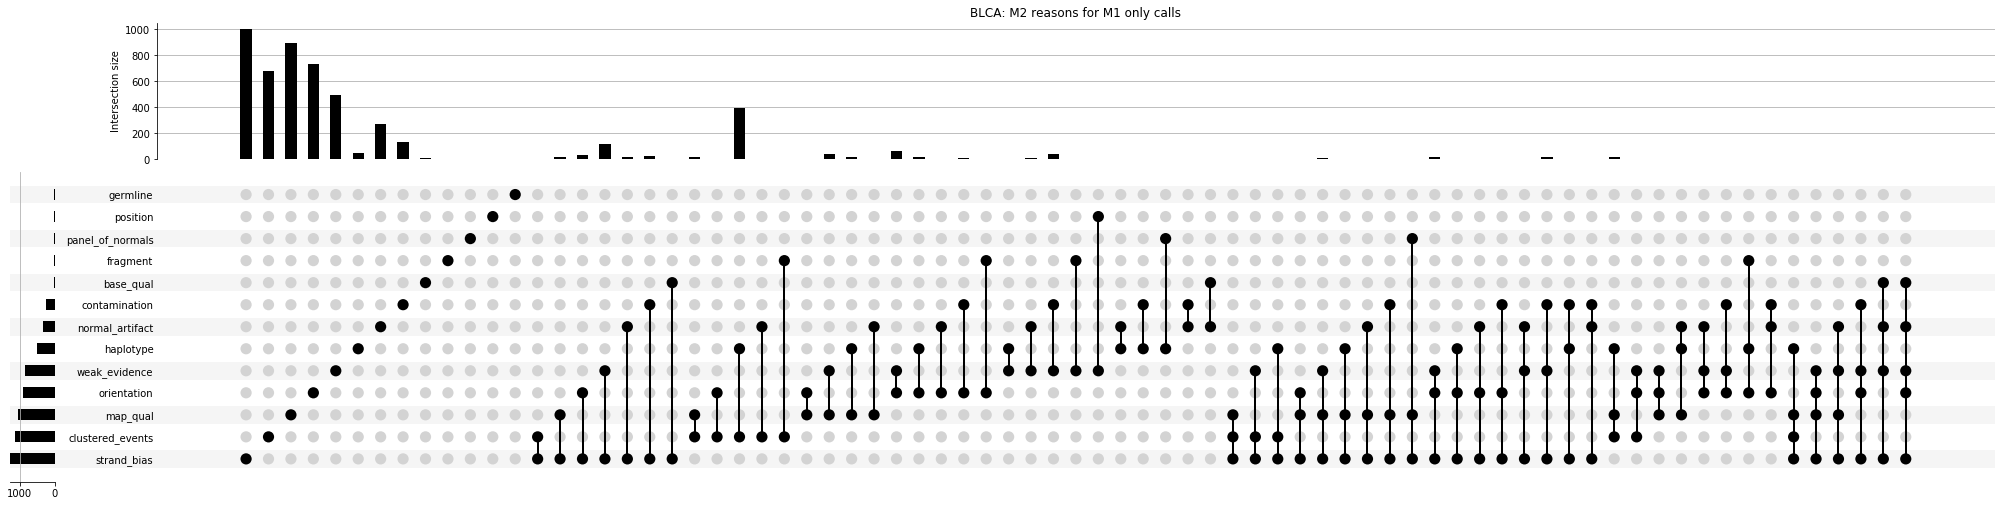

In [127]:

        
maf1, maf2 = compare_vis("BLCA")
target = plot_upset(maf1, maf2, "BLCA")

In [120]:
filter_df.patient

0         H_MJ-VS-A9UM-01A-11D-A42O-09
1         H_MJ-VS-A9UM-01A-11D-A42O-09
2         H_MJ-VS-A9UM-01A-11D-A42O-09
3         H_MJ-VS-A9UM-01A-11D-A42O-09
4         H_MJ-VS-A9UM-01A-11D-A42O-09
                      ...             
240481    H_MJ-JW-A5VH-01A-11D-A28B-09
240482    H_MJ-JW-A5VH-01A-11D-A28B-09
240483    H_MJ-JW-A5VH-01A-11D-A28B-09
240484    H_MJ-JW-A5VH-01A-11D-A28B-09
240485    H_MJ-JW-A5VH-01A-11D-A28B-09
Name: patient, Length: 240486, dtype: object

In [125]:
target

chr       pos                  patient ref_allele newbase  \
5        1    883899  CF-A47S-01A-11D-A23U-08          T       G   
8        1    949846  E7-A6MF-01A-12D-A32B-08          C       T   
9        1    981368  CF-A47Y-01A-11D-A23U-08          C       T   
10       1   1102490  5N-A9KI-01A-31D-A42E-08          C       T   
15       1   1246021  ZF-AA4U-01A-11D-A38G-08          C       T   
...    ...       ...                      ...        ...     ...   
20603   24   4968004  FD-A3SR-01A-11D-A22Z-08          C       T   
20604   24   4968262  GU-A767-01A-11D-A32B-08          G       T   
20605   24   4968272  GV-A6ZA-01A-12D-A339-08          G       C   
20607   24   4968463  4Z-AA7R-01A-11D-A391-08          G       T   
20612   24  16941831  FT-A61P-01A-11D-A30E-08          G       A   

                                       filters  \
5                  contamination;weak_evidence   
8      contamination;strand_bias;weak_evidence   
9                  contamination;weak_evidence   
10                                    germline   
15                               weak_evidence   
...                                        ...   
20603                                 map_qual   
20604                                 map_qual   
20605                                 map_qual   
20607                                 map_qual   
20612                                 map_qual   

                                                    info  
5      CONTQ=1;DP=102;ECNT=1;GERMQ=93;MBQ=33,27;MFRL=...  
8      CONTQ=5;DP=106;ECNT=1;GERMQ=93;MBQ=30,35;MFRL=...  
9      CONTQ=3;DP=136;ECNT=1;GERMQ=93;MBQ=32,35;MFRL=...  
10     CONTQ=93;DP=16;ECNT=1;GERMQ=2;MBQ=33,33;MFRL=1...  
15     CONTQ=37;DP=485;ECNT=1;GERMQ=93;MBQ=31,34;MFRL...  
...                                                  ...  
20603  CONTQ=20;DP=216;ECNT=1;GERMQ=93;MBQ=36,34;MFRL...  
20604  CONTQ=93;DP=81;ECNT=1;GERMQ=28;MBQ=35,33;MFRL=...  
20605  CONTQ=93;DP=95;ECNT=1;GERMQ=93;MBQ=34,35;MFRL=...  
20607  CONTQ=93;DP=42;ECNT=1;GERMQ=93;MBQ=33,27;MFRL=...  
20612  CONTQ=93;DP=124;ECNT=1;GERMQ=93;MBQ=30,32;MFRL...  

[5223 rows x 7 columns]

In [299]:
diff

array([ 2.900e+01,  2.300e+01,  4.000e+00,  1.800e+01,  1.500e+01,
        6.000e+00,  2.000e+02,  4.200e+01,  2.300e+01,  2.500e+01,
        1.100e+01,  3.000e+00,  4.000e+00, -5.000e+00,  1.800e+01,
       -1.000e+01,  3.000e+00, -1.300e+01, -2.100e+01, -1.400e+01,
       -1.000e+01, -1.400e+01, -5.000e+00, -5.000e+00,  1.000e+01,
        4.000e+00, -1.200e+01,  1.500e+01, -2.340e+02, -1.000e+00,
       -1.500e+01, -6.300e+01, -7.000e+00, -1.200e+01, -9.000e+00,
       -4.000e+00,  9.000e+00,  1.100e+01,  1.400e+01,  1.900e+01,
        6.000e+00,  1.000e+01,  1.900e+01,  7.000e+00,  1.600e+01,
        9.000e+00,  2.800e+01,  1.200e+01,  6.000e+00,  2.700e+01,
        2.000e+01,  1.100e+01,  1.800e+01,  2.900e+01,  9.000e+00,
        2.300e+01,  1.200e+01,  5.000e+00,  7.000e+00,  1.400e+01,
        7.400e+01,  4.700e+01,  3.700e+01,  3.100e+01,  2.700e+01,
        7.000e+00,  4.200e+01,  1.400e+02,  6.600e+01, -4.000e+00,
        7.000e+00, -7.000e+00,  1.700e+01,  1.600e+01,  1.160e

In [287]:
maf1r.dtypes

chr                int64
pos                int64
gene              object
ref_allele        object
newbase           object
type              object
classification    object
patient           object
ttype             object
dtype: object

In [282]:
maf2

chr        pos     gene ref_allele newbase         type  \
0         1    7812556  Unknown          C       T          IGR   
1         1   10197201  Unknown          C       G          IGR   
2         1   23645110  Unknown          C       T          IGR   
3         1   24413198  Unknown          C       T          IGR   
4         1  155147914  Unknown          T       A          IGR   
...     ...        ...      ...        ...     ...          ...   
103863   23   30870896     TAB3          G       A  Splice_site   
103864   23   39921444     BCOR          T       C     Missense   
103865   23   48801543    OTUD5          T       C  Splice_site   
103866   23   54985325   PFKFB1          G       A     Missense   
103867   23  153130485    L1CAM          C       T          IGR   

       classification                 patient ttype  
0                 SNP  S-A9UM-01A-11D-A42O-09  CESC  
1                 SNP  S-A9UM-01A-11D-A42O-09  CESC  
2                 SNP  S-A9UM-01A-11D-A42O-09  CESC  
3                 SNP  S-A9UM-01A-11D-A42O-09  CESC  
4                 SNP  S-A9UM-01A-11D-A42O-09  CESC  
...               ...                     ...   ...  
103863            SNP  W-A5VH-01A-11D-A28B-09  CESC  
103864            SNP  W-A5VH-01A-11D-A28B-09  CESC  
103865            SNP  W-A5VH-01A-11D-A28B-09  CESC  
103866            SNP  W-A5VH-01A-11D-A28B-09  CESC  
103867            SNP  W-A5VH-01A-11D-A28B-09  CESC  

[103868 rows x 9 columns]

In [285]:
maf2r

chr        pos      gene ref_allele newbase        type  \
0         1   52254900      NRD1          C       T         IGR   
1         1   70614211    LRRC40          G       C  Synonymous   
2         1   74575197    LRRIQ3          T       C    Missense   
3         1  120269466     PHGDH          C       A         IGR   
4         1  158641928     SPTA1          C       T    Missense   
...     ...        ...       ...        ...     ...         ...   
170502   23   29973573  IL1RAPL1          G       C    Missense   
170503   23   44922802     KDM6A          C       T    Nonsense   
170504   23   47308245     ZNF41          G       A  Synonymous   
170505   23   77224345     PGAM4          G       A         IGR   
170506   23   99926013     SRPX2          G       C         IGR   

       classification                 patient ttype  
0                 SNP  Y-A9G0-01A-12D-A38G-08  BLCA  
1                 SNP  Y-A9G0-01A-12D-A38G-08  BLCA  
2                 SNP  Y-A9G0-01A-12D-A38G-08  BLCA  
3                 SNP  Y-A9G0-01A-12D-A38G-08  BLCA  
4                 SNP  Y-A9G0-01A-12D-A38G-08  BLCA  
...               ...                     ...   ...  
170502            SNP  2-A2EL-01A-12D-A18F-08  BLCA  
170503            SNP  2-A2EL-01A-12D-A18F-08  BLCA  
170504            SNP  2-A2EL-01A-12D-A18F-08  BLCA  
170505            SNP  2-A2EL-01A-12D-A18F-08  BLCA  
170506            SNP  2-A2EL-01A-12D-A18F-08  BLCA  

[170507 rows x 9 columns]

In [211]:
maf10.patient.value_counts()

TCGA-W5-AA39-01A-11D-A417-09    1317
TCGA-W5-AA2U-01A-11D-A417-09     119
TCGA-W5-AA2Q-01A-11D-A417-09     105
TCGA-ZH-A8Y6-01A-11D-A417-09      93
TCGA-ZH-A8Y4-01A-11D-A417-09      92
TCGA-W5-AA30-01A-31D-A417-09      89
TCGA-ZU-A8S4-01A-11D-A417-09      86
TCGA-3X-AAVC-01A-21D-A417-09      85
TCGA-W5-AA2G-01A-11D-A417-09      84
TCGA-4G-AAZT-01A-11D-A417-09      79
TCGA-W5-AA2X-01A-11D-A417-09      79
TCGA-W5-AA36-01A-11D-A417-09      78
TCGA-ZH-A8Y2-01A-11D-A417-09      77
TCGA-W5-AA2Z-01A-11D-A417-09      76
TCGA-W5-AA2T-01A-12D-A417-09      75
TCGA-3X-AAV9-01A-72D-A417-09      75
TCGA-W5-AA2I-01A-32D-A417-09      71
TCGA-W5-AA34-01A-11D-A417-09      71
TCGA-WD-A7RX-01A-12D-A417-09      71
TCGA-ZH-A8Y1-01A-11D-A417-09      68
TCGA-3X-AAVE-01A-11D-A417-09      67
TCGA-3X-AAVA-01A-11D-A417-09      60
TCGA-W5-AA31-01A-11D-A417-09      60
TCGA-W6-AA0S-01A-11D-A417-09      57
TCGA-4G-AAZO-01A-12D-A417-09      57
TCGA-W5-AA38-01A-11D-A417-09      56
TCGA-ZD-A8I3-01A-11D-A417-09      55
T

In [212]:
len("W5-AA39-01A-11D-A417-09")

23

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


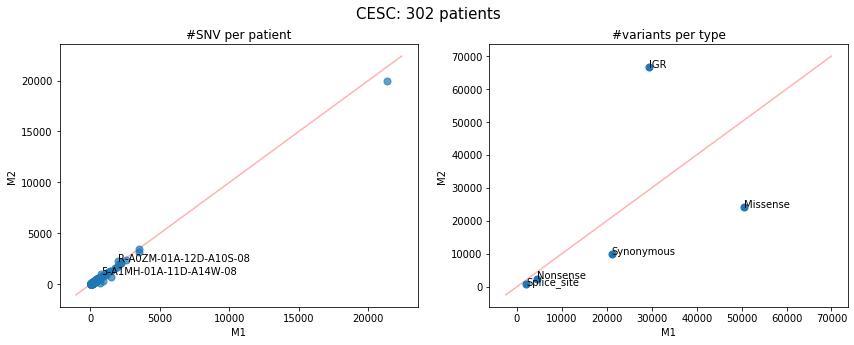

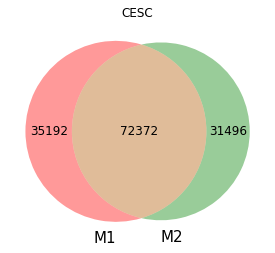

CESC upset error


<Figure size 432x288 with 0 Axes>

In [271]:
left, right, filter_df = compare_vis("CESC")

In [80]:
import pandas as pd
import numpy as np
import jpype
jpype.addClassPath("/demo-mount/tools/capyres/res/*")
jpype.startJVM()
FWB = jpype.JClass('org.broadinstitute.cga.tools.seq.FixedWidthBinary');
c65 = FWB("/demo-mount/tools/capyres/res/context65/all.fwb");
# load in your MAF as a Pandas dataframe, with columns chr, pos, ref, newbase
M = Frame
M = M.sort_values(["chr", "pos"]);
def jpa(a):
    return jpype.JArray(jpype.JInt)(a.values)
M = M.rename({"ref_allele": "ref"}, axis='columns')
# julian's gist
M["c65"] = np.array(c65.get(jpa(M["chr"]), jpa(M["pos"])), dtype = np.uint8) - 1;
jpype.shutdownJVM()
# now get ch96 values
M["is_SNP"] = np.in1d(M["ref"], list("ACGT")) & np.in1d(M["newbase"], list("ACGT"));
# index newbase
B = dict(zip(list("ACGT"), range(0, 4)));
M["nbidx"] = -1;
M.loc[M["is_SNP"], "nbidx"] = M.loc[M["is_SNP"], "newbase"].map(B);
M["c32"] = M["c65"];
GTidx = ((M["c65"] & 0x20) > 0) & M["is_SNP"];
# strand-collapse c65
x = (~np.r_[0:32]) & 0x3F;
x = (x & 0x30) | np.left_shift(x & 0x3, 2) | np.right_shift(x & 0xC, 2)
c32LuT = np.full(64, 0, dtype = np.uint8);
c32LuT[x] = np.r_[0:32];
M.loc[GTidx, "c32"] = c32LuT[M.loc[GTidx, "c32"]];
# combine c32 + newbase -> ch96
M.loc[GTidx, "nbidx"] = 3 - M.loc[GTidx, "nbidx"];
idx = (M["c32"] < 16) & M["is_SNP"];


M.loc[idx, "nbidx"] = M.loc[idx, "nbidx"] - 1;
idx = (M["c32"] >= 16) & M["is_SNP"] & (M["nbidx"] >= 2);
M.loc[idx, "nbidx"] = M.loc[idx, "nbidx"] - 1;
M["ch96"] = -1;
x = M.loc[M["is_SNP"], ["c32", "nbidx"]].values;
M.loc[M["is_SNP"], "ch96"] = ((x[:, 0] >= 16)*48 + 16*x[:, 1]) | (x[:, 0] & 0xF)

# julian's CA_py code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#
# LEGO plots {{{

#  TCAG
# T
# C
# A
# G
# 
# C>G C>A C>T   4 3 5
# A>T A>C A>G   2 0 1

# sort ch96 by row-major ordering according to LEGO layout
y = np.r_[0:96];

L = pd.DataFrame({ "ch" : np.right_shift(y & 0x70, 4), "l" : np.right_shift(y & 0xC, 2), "r" : y & 3})
L["ch_c"] = pd.Categorical(L["ch"], [4, 3, 5, 2, 0, 1]);
L["l_c"] = pd.Categorical(L["l"], [3, 1, 0, 2]);
L["r_c"] = pd.Categorical(L["r"], [3, 1, 0, 2]);

ch96_grid = np.hstack([
              np.reshape(L.loc[L["ch"] > 2, :] \
                         .sort_values(["ch_c", "r_c", "l_c"]).index.values, (-1, 4)),
              np.reshape(L.loc[L["ch"] < 3, :] \
                         .sort_values(["ch_c", "r_c", "l_c"]).index.values, (-1, 4))
]).T

lego_colors = np.array([0,   0.2, 0.8,
                        0.1, 0.8, 0.1,
                        0.5, 0.3, 0.7, 
                        0,   0.7, 0.7,
                        1,   0,   0,
                        1,   1,   0]).reshape(-1, 3);
lego_colors = lego_colors[np.right_shift(ch96_grid & 0x70, 4)];

def lego(ch96_counts, fnum = None, axes = None):
	xc, yc = np.meshgrid(np.r_[0:12], np.r_[0:8]);

	if axes is None:
		if fnum is None:
			f = plt.figure(); plt.clf()
			fnum = f.number
		else:
			f = plt.figure(fnum)

		ax = f.add_subplot(projection = '3d', proj_type = 'ortho', azim = 60)
	else:
		ax = axes

	# TODO: specify z-index of each bar individually
	#np.fliplr(xc + np.r_[0:88:11][:, None] + yc)

	ax.bar3d(xc.ravel(), yc.ravel(), 0, 0.8, 0.8, ch96_counts[ch96_grid].ravel(), lego_colors.reshape([96, 3, -1]).squeeze(), edgecolor = 'k', shade = False, zsort = 'max')
	ax.set_xlim3d(12.4, -0.6)
	ax.set_xticks([])
	ax.set_yticks([])

	return ax


[]

In [47]:
MC3.head()

chr    pos gene ref_allele newbase type classification  \
0    1  13308  NaN          T       G  IGR            SNP   
1    1  13372  NaN          G       T  IGR            SNP   
2    1  13501  NaN          G       A  IGR            SNP   
3    1  13515  NaN          C       A  IGR            SNP   
4    1  13516  NaN          C       A  IGR            SNP   

                        patient ttype  
0  TCGA-L5-A88V-01A-11D-A351-09  ESCA  
1  TCGA-EB-A3Y7-01A-11D-A23B-08  SKCM  
2  TCGA-CR-7386-01A-11D-2012-08  HNSC  
3  TCGA-06-0221-01A-01D-1491-08   GBM  
4  TCGA-06-0221-01A-01D-1491-08   GBM

In [11]:
dd = drs_avail.loc[drs_avail.cohort.isin(["COAD", "KIRP", "PCPG", "KIRC"]), ]
dd.to_csv("/demo-mount/smk_gs/drs_test.tsv", sep = "\t", index = False)

In [18]:
loc_togo.to_csv("/demo-mount/smk_gs/remain_paths.tsv", sep = "\t", index = False)

In [30]:
first_localize = (loc_togo.cohort.value_counts() < 100).index.tolist()[-10:]

In [35]:
tab1 = loc_togo.loc[loc_togo["cohort"].isin(first_localize),:]
tab1.to_csv("/demo-mount/smk-m2/tab1.tsv", sep = "\t", index = False)

In [13]:
gs_only = alldf.loc[(alldf["normal"].str[0:2] == "gs") & (alldf["tumor"].str[0:2] == "gs"),:]
gs_samples_togo = gs_only.loc[~gs_only["pid"].isin(finished),:]

In [15]:
gs_only.cohort.value_counts()

BRCA    1078
UCEC     544
LIHC     375
COAD     272
CESC     263
SARC     251
OV       199
ESCA     182
KIRP     170
KIRC     170
TGCT     150
THYM     121
READ     110
ACC       92
MESO      83
KICH      66
DLBC      44
CHOL      36
LAML      21
LUAD       2
LUSC       1
Name: cohort, dtype: int64